In [1]:
'''An example to show how to set up an pommerman game programmatically'''
import time
import pommerman
from util import flatten_state
from pommerman import agents
from pommerman import constants as c
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility
from pommerman import forward_model
from pommerman import constants

# Notebook 6.3
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ReinforceModel(forward_model.ForwardModel):
    def __init__(self):
        super().__init__()
    
    @staticmethod
    def get_rewards(agents, game_type, step_count, max_steps):

        def any_lst_equal(lst, values):
            '''Checks if list are equal'''
            return any([lst == v for v in values])

        alive_agents = [num for num, agent in enumerate(agents) \
                        if agent.is_alive]
        if game_type == constants.GameType.FFA:
            if len(alive_agents) == 1:
                # An agent won. Give them +1, others -1.
                return [2 * int(agent.is_alive) - 1 for agent in agents]
            elif step_count >= max_steps:
                # Game is over from time. Everyone gets -1.
                return [-1] * 4
            else:
                # Game running: 0 for alive, -1 for dead.
                
                return [int(agent.is_alive) - 1 for agent in agents]


class NewAgent(agents.BaseAgent):
    """The Random Agent that returns random actions given an action_space."""

    def __init__(self, Character=Bomber, *args, **kwargs):
        super(NewAgent,self).__init__(Character,*args, **kwargs)
        self.seq = [c.Action.Right, c.Action.Up, c.Action.Left, c.Action.Down]
        self.index = 0
    
    def act(self, obs, action_space):
        if self.index == 4:
            self.index = 0
        action = self.seq[self.index]
        self.index += 1
        return 0
    
# Print all possible environments in the Pommerman registry
print(pommerman.REGISTRY)

# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

# Create a set of agents (exactly four)
agent_list = [
    NewAgent(config["agent"](0, config["game_type"])),
    agents.SimpleAgent(config["agent"](1, config["game_type"])),
    agents.SimpleAgent(config["agent"](2, config["game_type"])),
    agents.RandomAgent(config["agent"](3, config["game_type"])),
    # agents.DockerAgent("pommerman/simple-agent", port=12345),
]

env.set_agents(agent_list)
env.set_training_agent(0) #<- Does not call act method on training agents in env.act
env.model = ReinforceModel()
env.set_init_game_state(None)

# Run the episodes just like OpenAI Gym
#for i_episode in range(1):
#    state = env.reset()
#    done = False
#    while not done:  
#        actions = env.act(state)
#        state, reward, done, info = env.step(actions)

        #Update


#    print('Episode {} finished'.format(i_episode))
#    print(info)
#time.sleep(2)
#env.close()

    

['PommeFFACompetition-v0', 'PommeFFACompetitionFast-v0', 'PommeFFAFast-v0', 'PommeFFA-v1', 'PommeRadio-v2', 'PommeTeamCompetition-v0', 'PommeTeamCompetitionFast-v0', 'PommeTeamCompetition-v1', 'PommeTeam-v0', 'PommeTeamFast-v0']


## Notebook 6.3 Network and Train

In [ ]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.ffn = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_outputs),
        )
        
        self.ffn.apply(self.init_weights)
        
        #self.hidden = nn.Linear(n_inputs, n_hidden)
        #self.hidden2 = nn.Linear(n_hidden, n_hidden)
        #self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = flatten_state(x)
        #print(x)
        #x = self.hidden(x)
        #x = F.relu(x)
        #x = F.relu(self.hidden2(x))
        #x = self.out(x)
        
        x = self.ffn(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))
    
    def init_weights(m, *args):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

# Example:
# def forward(self, x):
#     x = flatten_state(x)
# where x is np.atleast1d(S[0])

# Flattens a state s on the form list<dict> where each dict contains information of a state
#def flatten_state(s):
    #print("\n Flatten: ",s)
#    return torch.from_numpy(np.array([flatten_state_aux(x) for x in s])).float()

#def flatten_state_aux(s):
    # Lists
    #print("\n Augs: ",s)
#    alive = [1 if x in s['alive'] else 0 for x in range(10,14)]
    #print(alive)
#    board = s['board']
#    bomb_blast_strength = s['bomb_blast_strength']
#    bomb_life = s['bomb_life']
    # Tuples
#    position = s['position']
    # Ints
#    blast_strength = s['blast_strength']
#    can_kick = s['can_kick']
#    ammo = s['ammo']
    # Enums
#    teammate = s['teammate'] #9 for FFA
#    enemies = s['enemies'] #11,12,13 for FFA and training agent id = 0
    
#    a = np.append(np.array(alive),np.array(board).flatten())
#    a = np.append(a,np.array(bomb_blast_strength).flatten())
#    a = np.append(a,np.array(bomb_life).flatten())
#    a = np.append(a,position[0])
#    a = np.append(a,position[1])
#    a = np.append(a,blast_strength)
#    a = np.append(a,can_kick)
#    a = np.append(a,ammo)
    # Commented out as we get size 376 but expected 372. I assume we calculated wrong.
    # Makes sense to ignore these imo
    #a = np.append(a,teammate.value)
    #a = np.append(a,[e.value for e in enemies])
    #print(np.shape(a))
#    return a.astype(float)
    

# training settings
n_inputs = 372
n_hidden = 500
n_outputs = env.action_space.n

num_episodes = 100
#rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 0.9 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 25 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        done = False
        #policy.train()
        while not done:
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(np.atleast_1d(s[0]))
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            
            actions = env.act(s)
            actions.insert(0,a)
            
            #print(actions)
            
            s1, r, done, _ = env.step(actions)
            #print(r)
            rollout.append((s[0], a, r[0]))
            #print("\n\nrollout:",rollout,"\n\n")
            s = s1
        # prepare batch
        print('done with episode:',i)
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy([s[0] for s in states]).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        #policy.eval()
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                done = False
                while not done:
                    #env.render()
                    with torch.no_grad():
                        probs = policy(np.atleast_1d(s[0]))
                        a = probs.argmax().item()
                        print(probs, "max actions: ", a,probs.argmax())
                        
                    actions = env.act(s)
                    actions.insert(0,a)
                    
                    s, r, done, _ = env.step(actions)
                    reward += r[0]
                validation_rewards.append(reward)
                #env.render(close=True)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    env.close()
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
done with episode: 0
done with episode: 1
done with episode: 2
done with episode: 3
done with episode: 4
done with episode: 5
done with episode: 6
done with episode: 7
done with episode: 8
done with episode: 9
done with episode: 10
done with episode: 11
done with episode: 12
done with episode: 13
done with episode: 14
done with episode: 15
done with episode: 16
done with episode: 17
done with episode: 18
done with episode: 19
done with episode: 20
done with episode: 21
done with episode: 22
done with episode: 23
done with episode: 24
tensor([[5.4395e-05, 9.9985e-01, 1.0847e-05, 2.0195e-06, 7.9611e-05, 1.0874e-08]]) max actions:  1 tensor(1)
tensor([[1.5242e-04, 9.9933e-01, 7.7653e-05, 1.6425e-05, 4.1860e-04, 9.4743e-08]]) max actions:  1 tensor(1)
tensor([[4.1335e-05, 9.9984e-01, 1.8956e-05, 5.6049e-06, 9.3309e-05, 1.4903e-08]]) max actions:  1 tensor(1)
tensor([[4.3871e-05, 9.9988e-01, 6.8109e-06, 2.5043e-06, 6.3035e-05, 2.7363e-08]]) max actions:  1 tensor(1)
tensor([[

tensor([[2.5820e-03, 9.9332e-01, 6.1082e-04, 2.7151e-04, 3.2072e-03, 7.8402e-06]]) max actions:  1 tensor(1)
tensor([[5.5488e-04, 9.9842e-01, 2.3859e-04, 1.3625e-04, 6.5344e-04, 8.4225e-07]]) max actions:  1 tensor(1)
tensor([[1.9891e-04, 9.9957e-01, 2.0640e-05, 4.7619e-06, 2.0809e-04, 5.0100e-08]]) max actions:  1 tensor(1)
tensor([[1.8385e-04, 9.9882e-01, 6.7847e-05, 3.5064e-05, 8.9532e-04, 3.7675e-07]]) max actions:  1 tensor(1)
tensor([[1.9531e-06, 9.9999e-01, 4.3008e-07, 2.1406e-07, 7.5650e-06, 2.3452e-10]]) max actions:  1 tensor(1)
tensor([[4.2319e-06, 9.9999e-01, 8.3512e-07, 3.3232e-07, 8.9345e-06, 1.7798e-10]]) max actions:  1 tensor(1)
tensor([[1.8879e-05, 9.9990e-01, 2.0515e-06, 6.4227e-07, 7.6627e-05, 2.4517e-09]]) max actions:  1 tensor(1)
tensor([[6.9962e-05, 9.9986e-01, 7.6820e-06, 3.0041e-06, 6.2216e-05, 1.9000e-08]]) max actions:  1 tensor(1)
tensor([[6.8416e-05, 9.9968e-01, 1.2213e-05, 9.0210e-06, 2.2828e-04, 8.5487e-08]]) max actions:  1 tensor(1)
tensor([[5.2640e-05

tensor([[1.0827e-04, 9.9945e-01, 2.6908e-05, 4.3835e-06, 4.0629e-04, 2.6401e-08]]) max actions:  1 tensor(1)
tensor([[3.5378e-05, 9.9972e-01, 2.4159e-05, 6.0628e-06, 2.1710e-04, 2.0652e-08]]) max actions:  1 tensor(1)
tensor([[7.3510e-05, 9.9982e-01, 1.3090e-05, 9.2981e-06, 8.2738e-05, 4.6254e-08]]) max actions:  1 tensor(1)
tensor([[1.8662e-05, 9.9983e-01, 1.4059e-05, 8.3555e-06, 1.2551e-04, 2.4221e-08]]) max actions:  1 tensor(1)
tensor([[6.3802e-06, 9.9998e-01, 9.9259e-07, 2.8788e-07, 1.5343e-05, 2.8462e-10]]) max actions:  1 tensor(1)
tensor([[2.4563e-05, 9.9992e-01, 4.3882e-06, 1.2306e-06, 4.6231e-05, 2.2525e-09]]) max actions:  1 tensor(1)
tensor([[2.6592e-05, 9.9986e-01, 7.9094e-06, 2.5342e-06, 1.0724e-04, 9.0043e-09]]) max actions:  1 tensor(1)
tensor([[2.3781e-04, 9.9846e-01, 1.5079e-04, 2.3074e-05, 1.1251e-03, 5.4069e-07]]) max actions:  1 tensor(1)
tensor([[3.6316e-05, 9.9990e-01, 8.3003e-06, 1.6579e-06, 5.1875e-05, 7.9576e-09]]) max actions:  1 tensor(1)
tensor([[1.2281e-04

tensor([[0.0056, 0.9868, 0.0011, 0.0006, 0.0058, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0028, 0.9935, 0.0007, 0.0004, 0.0025, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.3626e-03, 9.9582e-01, 3.6702e-04, 1.6239e-04, 2.2853e-03, 6.5943e-06]]) max actions:  1 tensor(1)
tensor([[1.3159e-03, 9.9527e-01, 5.2521e-04, 2.4802e-04, 2.6406e-03, 4.8368e-06]]) max actions:  1 tensor(1)
tensor([[2.2075e-04, 9.9886e-01, 1.2913e-04, 6.2192e-05, 7.3232e-04, 5.3789e-07]]) max actions:  1 tensor(1)
tensor([[3.4690e-03, 9.9260e-01, 6.3098e-04, 2.6478e-04, 3.0239e-03, 8.3413e-06]]) max actions:  1 tensor(1)
tensor([[2.6461e-04, 9.9928e-01, 5.4682e-05, 1.7698e-05, 3.8109e-04, 2.0497e-07]]) max actions:  1 tensor(1)
tensor([[4.2241e-05, 9.9982e-01, 9.9303e-06, 2.9016e-06, 1.2069e-04, 5.3054e-09]]) max actions:  1 tensor(1)
tensor([[9.9506e-04, 9.9731e-01, 3.5086e-04, 1.7014e-04, 1.1739e-03, 2.6732e-06]]) max actions:  1 tensor(1)
tensor([[3.6125e-03, 9.9361e-01, 8.1275e-04, 4.1014e-04, 1.5501e-03

tensor([[8.6581e-04, 9.9594e-01, 3.8486e-04, 1.4524e-04, 2.6543e-03, 5.2388e-06]]) max actions:  1 tensor(1)
tensor([[2.1960e-04, 9.9947e-01, 8.3097e-05, 2.0807e-05, 2.0304e-04, 5.4161e-07]]) max actions:  1 tensor(1)
tensor([[6.1097e-05, 9.9976e-01, 3.0272e-05, 1.2394e-05, 1.3437e-04, 5.0814e-08]]) max actions:  1 tensor(1)
tensor([[3.0268e-04, 9.9902e-01, 9.0721e-05, 3.8308e-05, 5.4757e-04, 7.9729e-07]]) max actions:  1 tensor(1)
tensor([[1.4601e-04, 9.9968e-01, 1.3786e-05, 8.8228e-06, 1.5358e-04, 2.8221e-08]]) max actions:  1 tensor(1)
tensor([[2.6997e-04, 9.9942e-01, 4.7512e-05, 1.3280e-05, 2.5187e-04, 5.1462e-08]]) max actions:  1 tensor(1)
tensor([[1.3965e-05, 9.9995e-01, 4.7197e-06, 1.2475e-06, 2.5292e-05, 2.6280e-09]]) max actions:  1 tensor(1)
tensor([[1.7154e-04, 9.9965e-01, 1.5597e-05, 7.8933e-06, 1.5588e-04, 5.3307e-08]]) max actions:  1 tensor(1)
tensor([[7.9552e-05, 9.9981e-01, 2.4491e-05, 5.7578e-06, 8.3447e-05, 1.5533e-08]]) max actions:  1 tensor(1)
tensor([[1.2828e-04

tensor([[7.2467e-05, 9.9978e-01, 9.2034e-06, 2.2785e-06, 1.4105e-04, 2.1603e-08]]) max actions:  1 tensor(1)
tensor([[8.1568e-04, 9.9840e-01, 9.0817e-05, 4.5368e-05, 6.4708e-04, 1.1300e-06]]) max actions:  1 tensor(1)
tensor([[4.1931e-05, 9.9986e-01, 5.4151e-06, 2.8228e-06, 9.2246e-05, 1.0742e-08]]) max actions:  1 tensor(1)
tensor([[6.8245e-04, 9.9787e-01, 1.1470e-04, 1.2565e-04, 1.2101e-03, 1.8887e-06]]) max actions:  1 tensor(1)
tensor([[9.5514e-04, 9.9707e-01, 2.4138e-04, 7.6981e-05, 1.6562e-03, 3.3680e-06]]) max actions:  1 tensor(1)
tensor([[4.1780e-04, 9.9789e-01, 2.8421e-04, 1.4222e-04, 1.2688e-03, 1.6444e-06]]) max actions:  1 tensor(1)
tensor([[3.4210e-04, 9.9934e-01, 5.4337e-05, 2.9886e-05, 2.2913e-04, 4.9346e-07]]) max actions:  1 tensor(1)
tensor([[1.8100e-04, 9.9960e-01, 3.1537e-05, 7.3178e-06, 1.8308e-04, 3.7396e-08]]) max actions:  1 tensor(1)
tensor([[1.6963e-04, 9.9946e-01, 4.5849e-05, 1.9633e-05, 3.0599e-04, 3.2756e-07]]) max actions:  1 tensor(1)
tensor([[9.1633e-05

tensor([[5.1239e-04, 9.9856e-01, 1.1948e-04, 3.8212e-05, 7.7317e-04, 1.0765e-06]]) max actions:  1 tensor(1)
tensor([[1.7855e-04, 9.9942e-01, 3.4104e-05, 3.1203e-05, 3.3926e-04, 3.9049e-07]]) max actions:  1 tensor(1)
tensor([[5.6774e-05, 9.9981e-01, 8.8960e-06, 2.7202e-06, 1.2214e-04, 1.6936e-08]]) max actions:  1 tensor(1)
tensor([[1.4800e-04, 9.9971e-01, 1.2102e-05, 3.2231e-06, 1.2505e-04, 2.0614e-08]]) max actions:  1 tensor(1)
tensor([[4.5199e-05, 9.9988e-01, 4.0561e-06, 2.5923e-06, 6.9938e-05, 2.4509e-08]]) max actions:  1 tensor(1)
tensor([[9.5703e-05, 9.9969e-01, 1.5821e-05, 7.4982e-06, 1.9144e-04, 2.7327e-08]]) max actions:  1 tensor(1)
tensor([[6.5021e-05, 9.9980e-01, 2.4288e-05, 4.6184e-06, 1.0315e-04, 1.7073e-08]]) max actions:  1 tensor(1)
tensor([[2.8974e-04, 9.9910e-01, 1.5592e-04, 4.5069e-05, 4.1263e-04, 3.8246e-07]]) max actions:  1 tensor(1)
tensor([[4.6493e-04, 9.9854e-01, 1.4474e-04, 4.4671e-05, 8.0090e-04, 4.7239e-07]]) max actions:  1 tensor(1)
tensor([[7.5851e-05

tensor([[6.5080e-04, 9.9718e-01, 6.2367e-04, 2.2441e-04, 1.3172e-03, 8.4368e-06]]) max actions:  1 tensor(1)
tensor([[5.8941e-04, 9.9857e-01, 2.1408e-04, 5.6453e-05, 5.6930e-04, 1.4822e-06]]) max actions:  1 tensor(1)
tensor([[8.7816e-04, 9.9703e-01, 4.4932e-04, 1.2860e-04, 1.5136e-03, 3.5335e-06]]) max actions:  1 tensor(1)
tensor([[5.3557e-04, 9.9755e-01, 1.6050e-04, 9.4758e-05, 1.6524e-03, 1.8507e-06]]) max actions:  1 tensor(1)
tensor([[1.6242e-04, 9.9938e-01, 8.5401e-05, 4.5332e-05, 3.2731e-04, 2.9714e-07]]) max actions:  1 tensor(1)
tensor([[5.0417e-04, 9.9844e-01, 1.2577e-04, 6.5582e-05, 8.6352e-04, 9.7419e-07]]) max actions:  1 tensor(1)
tensor([[2.3825e-04, 9.9907e-01, 8.5472e-05, 3.0837e-05, 5.7697e-04, 2.5697e-07]]) max actions:  1 tensor(1)
tensor([[4.7058e-04, 9.9890e-01, 1.0941e-04, 3.5491e-05, 4.8673e-04, 5.8447e-07]]) max actions:  1 tensor(1)
tensor([[1.8339e-04, 9.9843e-01, 9.9591e-05, 4.1102e-05, 1.2456e-03, 4.3395e-07]]) max actions:  1 tensor(1)
tensor([[7.9350e-04

tensor([[8.4421e-04, 9.9736e-01, 1.2284e-04, 7.2839e-05, 1.5950e-03, 2.5857e-06]]) max actions:  1 tensor(1)
tensor([[7.0617e-04, 9.9691e-01, 1.6728e-04, 1.5313e-04, 2.0547e-03, 6.1395e-06]]) max actions:  1 tensor(1)
tensor([[0.0018, 0.9945, 0.0010, 0.0003, 0.0023, 0.0000]]) max actions:  1 tensor(1)
tensor([[8.6257e-04, 9.9798e-01, 1.7871e-04, 1.3854e-04, 8.3481e-04, 2.5875e-06]]) max actions:  1 tensor(1)
tensor([[1.9673e-03, 9.9621e-01, 3.1226e-04, 1.4230e-04, 1.3644e-03, 2.6583e-06]]) max actions:  1 tensor(1)
tensor([[3.3593e-04, 9.9624e-01, 2.0009e-04, 8.0393e-05, 3.1458e-03, 1.3892e-06]]) max actions:  1 tensor(1)
tensor([[8.6097e-04, 9.9714e-01, 4.8756e-04, 2.2771e-04, 1.2780e-03, 3.8021e-06]]) max actions:  1 tensor(1)
tensor([[4.3480e-04, 9.9859e-01, 1.7019e-04, 6.8599e-05, 7.3624e-04, 8.0731e-07]]) max actions:  1 tensor(1)
tensor([[0.0035, 0.9906, 0.0010, 0.0006, 0.0043, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0033, 0.9905, 0.0010, 0.0007, 0.0044, 0.0000]]) max acti

tensor([[0.0050, 0.9841, 0.0029, 0.0015, 0.0065, 0.0001]]) max actions:  1 tensor(1)
tensor([[0.0052, 0.9864, 0.0025, 0.0012, 0.0047, 0.0001]]) max actions:  1 tensor(1)
tensor([[1.3783e-03, 9.9626e-01, 3.8646e-04, 1.0745e-04, 1.8653e-03, 5.5516e-06]]) max actions:  1 tensor(1)
tensor([[0.0023, 0.9927, 0.0008, 0.0008, 0.0033, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0044, 0.9879, 0.0012, 0.0007, 0.0059, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0142, 0.9737, 0.0020, 0.0014, 0.0086, 0.0001]]) max actions:  1 tensor(1)
tensor([[0.0024, 0.9846, 0.0017, 0.0010, 0.0102, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0068, 0.9811, 0.0020, 0.0013, 0.0088, 0.0001]]) max actions:  1 tensor(1)
tensor([[0.0043, 0.9824, 0.0027, 0.0014, 0.0091, 0.0001]]) max actions:  1 tensor(1)
tensor([[0.0034, 0.9901, 0.0011, 0.0005, 0.0048, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0028, 0.9893, 0.0011, 0.0008, 0.0060, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0053, 0.9771, 0.0044, 0.0028, 

tensor([[6.1630e-05, 9.9990e-01, 3.8166e-06, 1.7206e-06, 3.7309e-05, 3.1088e-09]]) max actions:  1 tensor(1)
tensor([[3.4078e-05, 9.9992e-01, 3.6551e-06, 7.9663e-07, 4.1996e-05, 6.0488e-09]]) max actions:  1 tensor(1)
tensor([[5.2401e-05, 9.9988e-01, 4.9294e-06, 1.6188e-06, 6.0448e-05, 9.5753e-09]]) max actions:  1 tensor(1)
tensor([[1.7105e-06, 9.9999e-01, 1.2225e-07, 4.0175e-08, 4.9536e-06, 3.5893e-11]]) max actions:  1 tensor(1)
tensor([[4.4863e-06, 9.9999e-01, 6.4265e-07, 2.5860e-07, 3.3929e-06, 3.2758e-10]]) max actions:  1 tensor(1)
tensor([[9.7976e-06, 9.9997e-01, 2.1580e-06, 3.3570e-07, 1.5865e-05, 3.1954e-10]]) max actions:  1 tensor(1)
tensor([[1.1207e-06, 9.9999e-01, 2.4417e-07, 6.9183e-08, 1.2329e-05, 1.7439e-10]]) max actions:  1 tensor(1)
tensor([[2.3739e-05, 9.9992e-01, 2.3422e-06, 7.9791e-07, 4.8634e-05, 2.0235e-09]]) max actions:  1 tensor(1)
tensor([[2.7475e-05, 9.9985e-01, 4.7064e-06, 4.4974e-07, 1.1261e-04, 3.8392e-09]]) max actions:  1 tensor(1)
tensor([[8.4052e-06

tensor([[2.9155e-04, 9.9926e-01, 6.6303e-05, 4.1794e-05, 3.3633e-04, 4.5735e-07]]) max actions:  1 tensor(1)
tensor([[1.4177e-04, 9.9958e-01, 4.8024e-05, 1.2724e-05, 2.1767e-04, 9.2221e-08]]) max actions:  1 tensor(1)
tensor([[9.6727e-04, 9.9763e-01, 2.4115e-04, 7.9154e-05, 1.0845e-03, 1.6713e-06]]) max actions:  1 tensor(1)
tensor([[1.7814e-04, 9.9907e-01, 6.4568e-05, 2.9056e-05, 6.5566e-04, 2.1312e-07]]) max actions:  1 tensor(1)
tensor([[1.3443e-04, 9.9969e-01, 3.4442e-05, 8.6278e-06, 1.3453e-04, 4.5287e-08]]) max actions:  1 tensor(1)
tensor([[3.2575e-04, 9.9921e-01, 8.1317e-05, 1.9421e-05, 3.6571e-04, 4.3304e-07]]) max actions:  1 tensor(1)
tensor([[4.1568e-04, 9.9925e-01, 4.6342e-05, 1.9570e-05, 2.6344e-04, 2.1854e-07]]) max actions:  1 tensor(1)
tensor([[1.6767e-04, 9.9955e-01, 5.3929e-05, 9.4782e-06, 2.1550e-04, 4.2415e-08]]) max actions:  1 tensor(1)
tensor([[2.5218e-05, 9.9989e-01, 1.4030e-05, 2.9822e-06, 6.8989e-05, 1.3838e-08]]) max actions:  1 tensor(1)
tensor([[3.5817e-04

tensor([[1.3767e-04, 9.9944e-01, 4.8153e-05, 2.5528e-05, 3.4897e-04, 2.5611e-07]]) max actions:  1 tensor(1)
tensor([[0.0046, 0.9882, 0.0017, 0.0007, 0.0048, 0.0000]]) max actions:  1 tensor(1)
tensor([[5.1644e-04, 9.9867e-01, 1.8395e-04, 5.6721e-05, 5.7719e-04, 6.7421e-07]]) max actions:  1 tensor(1)
tensor([[6.8209e-04, 9.9792e-01, 2.9495e-04, 9.0552e-05, 1.0079e-03, 1.7866e-06]]) max actions:  1 tensor(1)
tensor([[1.2973e-03, 9.9751e-01, 2.6516e-04, 1.4243e-04, 7.7676e-04, 6.0450e-06]]) max actions:  1 tensor(1)
tensor([[0.0028, 0.9856, 0.0018, 0.0005, 0.0093, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.1905e-03, 9.9591e-01, 3.1946e-04, 1.6359e-04, 2.4130e-03, 6.6130e-06]]) max actions:  1 tensor(1)
tensor([[0.0016, 0.9938, 0.0010, 0.0006, 0.0029, 0.0000]]) max actions:  1 tensor(1)
tensor([[5.3239e-04, 9.9842e-01, 1.8455e-04, 1.5598e-04, 7.0718e-04, 1.3322e-06]]) max actions:  1 tensor(1)
tensor([[5.6784e-04, 9.9805e-01, 2.3988e-04, 9.8887e-05, 1.0413e-03, 1.8476e-06]]) max acti

tensor([[5.8994e-05, 9.9988e-01, 9.9744e-06, 1.0260e-06, 4.7238e-05, 1.3143e-08]]) max actions:  1 tensor(1)
tensor([[1.4068e-05, 9.9990e-01, 2.6661e-06, 6.1248e-07, 7.8599e-05, 2.9994e-09]]) max actions:  1 tensor(1)
tensor([[3.9505e-05, 9.9988e-01, 6.9051e-06, 2.3760e-06, 7.2666e-05, 6.8107e-09]]) max actions:  1 tensor(1)
tensor([[1.2857e-05, 9.9998e-01, 3.0964e-07, 1.1348e-07, 1.0049e-05, 1.2409e-10]]) max actions:  1 tensor(1)
tensor([[2.2584e-05, 9.9993e-01, 2.7790e-06, 2.7271e-06, 3.7888e-05, 2.5054e-09]]) max actions:  1 tensor(1)
tensor([[4.3424e-06, 9.9998e-01, 6.8857e-07, 1.7366e-07, 1.6911e-05, 4.3115e-10]]) max actions:  1 tensor(1)
tensor([[4.0998e-05, 9.9988e-01, 3.2241e-06, 1.3351e-06, 7.1031e-05, 5.6767e-09]]) max actions:  1 tensor(1)
tensor([[4.6693e-05, 9.9981e-01, 8.4537e-06, 2.2099e-06, 1.3745e-04, 5.4307e-09]]) max actions:  1 tensor(1)
tensor([[1.0175e-04, 9.9974e-01, 1.4003e-05, 7.7245e-06, 1.3403e-04, 8.2712e-08]]) max actions:  1 tensor(1)
tensor([[2.1650e-04

tensor([[5.3615e-06, 9.9997e-01, 1.5683e-06, 2.9483e-07, 2.0052e-05, 3.5087e-10]]) max actions:  1 tensor(1)
tensor([[3.1188e-04, 9.9917e-01, 1.3962e-04, 4.1198e-05, 3.3857e-04, 4.6886e-07]]) max actions:  1 tensor(1)
tensor([[3.0739e-05, 9.9992e-01, 4.8480e-06, 2.4903e-06, 4.4035e-05, 6.5362e-09]]) max actions:  1 tensor(1)
tensor([[2.2495e-04, 9.9948e-01, 9.3943e-05, 3.8020e-05, 1.6555e-04, 1.9047e-07]]) max actions:  1 tensor(1)
tensor([[2.8027e-04, 9.9934e-01, 6.3501e-05, 1.6265e-05, 2.9578e-04, 7.3495e-07]]) max actions:  1 tensor(1)
tensor([[1.3011e-05, 9.9996e-01, 1.2727e-06, 8.3726e-07, 2.8187e-05, 1.6108e-09]]) max actions:  1 tensor(1)
tensor([[4.0900e-05, 9.9983e-01, 2.3890e-05, 2.9280e-06, 9.9227e-05, 1.4746e-08]]) max actions:  1 tensor(1)
tensor([[2.1903e-05, 9.9995e-01, 1.8491e-06, 3.9456e-07, 2.9980e-05, 2.3765e-09]]) max actions:  1 tensor(1)
tensor([[1.3241e-05, 9.9995e-01, 2.4040e-06, 3.1048e-07, 3.0217e-05, 4.6310e-10]]) max actions:  1 tensor(1)
tensor([[1.0171e-05

tensor([[4.5112e-04, 9.9760e-01, 1.6919e-04, 2.9113e-05, 1.7500e-03, 6.1731e-07]]) max actions:  1 tensor(1)
tensor([[6.6483e-04, 9.9673e-01, 1.5642e-04, 1.0816e-04, 2.3378e-03, 1.3425e-06]]) max actions:  1 tensor(1)
tensor([[6.0385e-04, 9.9766e-01, 1.9140e-04, 1.4154e-04, 1.3992e-03, 1.5670e-06]]) max actions:  1 tensor(1)
tensor([[4.0654e-04, 9.9894e-01, 7.5891e-05, 3.7446e-05, 5.3670e-04, 1.7088e-07]]) max actions:  1 tensor(1)
tensor([[1.2523e-04, 9.9960e-01, 6.1704e-05, 1.6139e-05, 1.9366e-04, 1.0901e-07]]) max actions:  1 tensor(1)
tensor([[1.1510e-04, 9.9967e-01, 1.9369e-05, 9.1619e-06, 1.8361e-04, 6.6118e-08]]) max actions:  1 tensor(1)
tensor([[1.0950e-04, 9.9950e-01, 4.2304e-05, 2.8002e-05, 3.1938e-04, 2.9365e-07]]) max actions:  1 tensor(1)
tensor([[5.6910e-04, 9.9836e-01, 1.0366e-04, 5.9460e-05, 9.1173e-04, 6.7920e-07]]) max actions:  1 tensor(1)
tensor([[2.5673e-04, 9.9913e-01, 7.8363e-05, 2.9253e-05, 5.0553e-04, 2.5634e-07]]) max actions:  1 tensor(1)
tensor([[7.5361e-04

tensor([[1.1947e-03, 9.9497e-01, 6.7667e-04, 3.1229e-04, 2.8380e-03, 6.9152e-06]]) max actions:  1 tensor(1)
tensor([[2.3870e-04, 9.9817e-01, 1.7805e-04, 6.2824e-05, 1.3489e-03, 1.6693e-06]]) max actions:  1 tensor(1)
tensor([[1.0845e-03, 9.9715e-01, 4.9490e-04, 2.0673e-04, 1.0623e-03, 2.9628e-06]]) max actions:  1 tensor(1)
tensor([[6.5826e-04, 9.9813e-01, 1.0435e-04, 6.4640e-05, 1.0420e-03, 9.1100e-07]]) max actions:  1 tensor(1)
tensor([[8.3356e-04, 9.9791e-01, 2.3466e-04, 6.6461e-05, 9.5859e-04, 1.5676e-06]]) max actions:  1 tensor(1)
tensor([[1.5373e-03, 9.9576e-01, 3.2693e-04, 2.7850e-04, 2.0846e-03, 7.8848e-06]]) max actions:  1 tensor(1)
tensor([[6.6358e-04, 9.9751e-01, 2.6590e-04, 1.1178e-04, 1.4446e-03, 1.1844e-06]]) max actions:  1 tensor(1)
tensor([[4.6839e-04, 9.9824e-01, 1.3164e-04, 4.6740e-05, 1.1158e-03, 1.4416e-06]]) max actions:  1 tensor(1)
tensor([[1.4883e-04, 9.9876e-01, 1.1734e-04, 2.9824e-05, 9.4219e-04, 2.2740e-07]]) max actions:  1 tensor(1)
tensor([[1.1612e-04

tensor([[0.0015, 0.9926, 0.0011, 0.0005, 0.0043, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0038, 0.9863, 0.0028, 0.0006, 0.0064, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0026, 0.9920, 0.0013, 0.0007, 0.0034, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0016, 0.9905, 0.0012, 0.0003, 0.0064, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0026, 0.9923, 0.0010, 0.0005, 0.0036, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.4770e-03, 9.9561e-01, 2.0405e-04, 1.3050e-04, 2.5716e-03, 2.8648e-06]]) max actions:  1 tensor(1)
tensor([[1.6353e-03, 9.9682e-01, 1.9118e-04, 1.2298e-04, 1.2279e-03, 3.6279e-06]]) max actions:  1 tensor(1)
tensor([[1.6613e-03, 9.9400e-01, 7.4293e-04, 2.5201e-04, 3.3328e-03, 9.3134e-06]]) max actions:  1 tensor(1)
tensor([[8.3362e-04, 9.9712e-01, 2.8861e-04, 1.2757e-04, 1.6327e-03, 1.7030e-06]]) max actions:  1 tensor(1)
tensor([[0.0023, 0.9918, 0.0009, 0.0005, 0.0045, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.1697e-03, 9.9536e-01, 8.8753e-04, 1.6104e-0

tensor([[5.1103e-04, 9.9800e-01, 2.6940e-04, 1.1306e-04, 1.1011e-03, 8.7708e-07]]) max actions:  1 tensor(1)
tensor([[2.2504e-03, 9.9386e-01, 7.2680e-04, 3.0267e-04, 2.8592e-03, 5.4768e-06]]) max actions:  1 tensor(1)
tensor([[6.1247e-04, 9.9808e-01, 2.3028e-04, 1.0146e-04, 9.7035e-04, 1.4620e-06]]) max actions:  1 tensor(1)
tensor([[5.7778e-04, 9.9849e-01, 1.8383e-04, 6.1806e-05, 6.8299e-04, 1.6734e-06]]) max actions:  1 tensor(1)
tensor([[1.9014e-03, 9.9301e-01, 8.8049e-04, 4.8905e-04, 3.7126e-03, 7.8505e-06]]) max actions:  1 tensor(1)
tensor([[0.0016, 0.9942, 0.0011, 0.0004, 0.0027, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0022, 0.9904, 0.0015, 0.0005, 0.0054, 0.0000]]) max actions:  1 tensor(1)
tensor([[9.1190e-04, 9.9616e-01, 4.9307e-04, 1.8369e-04, 2.2407e-03, 6.3732e-06]]) max actions:  1 tensor(1)
tensor([[0.0046, 0.9878, 0.0012, 0.0004, 0.0059, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.1777e-03, 9.9491e-01, 5.5937e-04, 2.1243e-04, 3.1389e-03, 4.6966e-06]]) max acti

tensor([[5.6034e-04, 9.9792e-01, 1.7601e-04, 1.2096e-04, 1.2156e-03, 2.7324e-06]]) max actions:  1 tensor(1)
tensor([[7.4065e-04, 9.9770e-01, 1.7440e-04, 1.4318e-04, 1.2439e-03, 1.3280e-06]]) max actions:  1 tensor(1)
tensor([[0.0027, 0.9894, 0.0009, 0.0005, 0.0065, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.2665e-03, 9.9600e-01, 4.9902e-04, 2.0528e-04, 2.0223e-03, 2.9169e-06]]) max actions:  1 tensor(1)
tensor([[7.2683e-04, 9.9729e-01, 1.4626e-04, 7.9086e-05, 1.7548e-03, 1.0805e-06]]) max actions:  1 tensor(1)
tensor([[6.2475e-04, 9.9771e-01, 2.1336e-04, 1.8356e-04, 1.2647e-03, 4.0922e-06]]) max actions:  1 tensor(1)
tensor([[1.2545e-03, 9.9550e-01, 4.6824e-04, 1.5453e-04, 2.6116e-03, 6.5523e-06]]) max actions:  1 tensor(1)
tensor([[0.0027, 0.9899, 0.0014, 0.0009, 0.0051, 0.0000]]) max actions:  1 tensor(1)
tensor([[0.0028, 0.9929, 0.0007, 0.0003, 0.0033, 0.0000]]) max actions:  1 tensor(1)
tensor([[2.9786e-04, 9.9876e-01, 1.2930e-04, 3.4411e-05, 7.8171e-04, 5.0412e-07]]) max acti

tensor([[0.0070, 0.9762, 0.0036, 0.0013, 0.0118, 0.0001]]) max actions:  1 tensor(1)
tensor([[3.6416e-04, 9.9731e-01, 2.4140e-04, 8.9682e-05, 1.9941e-03, 6.6003e-07]]) max actions:  1 tensor(1)
tensor([[0.0064, 0.9817, 0.0014, 0.0014, 0.0090, 0.0001]]) max actions:  1 tensor(1)
tensor([[9.9091e-04, 9.9441e-01, 4.5739e-04, 1.0242e-04, 4.0400e-03, 4.3000e-06]]) max actions:  1 tensor(1)
tensor([[7.4536e-04, 9.9776e-01, 2.5163e-04, 7.9225e-05, 1.1650e-03, 1.9611e-06]]) max actions:  1 tensor(1)
tensor([[1.9898e-03, 9.9580e-01, 3.6157e-04, 1.7724e-04, 1.6690e-03, 4.9319e-06]]) max actions:  1 tensor(1)
tensor([[1.0973e-03, 9.9587e-01, 3.7355e-04, 4.3360e-04, 2.2202e-03, 6.2111e-06]]) max actions:  1 tensor(1)
tensor([[0.0073, 0.9762, 0.0025, 0.0018, 0.0121, 0.0001]]) max actions:  1 tensor(1)
tensor([[1.4905e-03, 9.9586e-01, 3.4035e-04, 2.7900e-04, 2.0217e-03, 8.3866e-06]]) max actions:  1 tensor(1)
tensor([[0.0080, 0.9792, 0.0028, 0.0016, 0.0083, 0.0001]]) max actions:  1 tensor(1)
tensor

tensor([[0.0046, 0.9812, 0.0025, 0.0015, 0.0101, 0.0001]]) max actions:  1 tensor(1)
tensor([[0.0043, 0.9857, 0.0010, 0.0009, 0.0081, 0.0001]]) max actions:  1 tensor(1)
tensor([[0.0030, 0.9909, 0.0008, 0.0007, 0.0045, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.3991e-03, 9.9478e-01, 4.8982e-04, 2.0010e-04, 3.1296e-03, 5.7443e-06]]) max actions:  1 tensor(1)
tensor([[0.0037, 0.9890, 0.0017, 0.0006, 0.0050, 0.0001]]) max actions:  1 tensor(1)
tensor([[2.4220e-03, 9.9314e-01, 5.5467e-04, 3.6299e-04, 3.5137e-03, 6.2218e-06]]) max actions:  1 tensor(1)
tensor([[1.9584e-03, 9.9507e-01, 5.9420e-04, 2.3626e-04, 2.1293e-03, 7.7736e-06]]) max actions:  1 tensor(1)
tensor([[8.4377e-04, 9.9729e-01, 1.7507e-04, 8.5896e-05, 1.6018e-03, 2.4373e-06]]) max actions:  1 tensor(1)
tensor([[0.0022, 0.9936, 0.0005, 0.0005, 0.0032, 0.0000]]) max actions:  1 tensor(1)
tensor([[2.0404e-03, 9.9586e-01, 3.4356e-04, 1.5545e-04, 1.5936e-03, 4.7776e-06]]) max actions:  1 tensor(1)
tensor([[0.0027, 0.9904, 0.001

tensor([[6.0121e-06, 9.9997e-01, 4.1488e-07, 2.0447e-07, 2.0990e-05, 4.9221e-10]]) max actions:  1 tensor(1)
tensor([[3.4473e-06, 9.9997e-01, 1.5982e-06, 4.1539e-07, 2.4237e-05, 8.1387e-10]]) max actions:  1 tensor(1)
tensor([[1.1703e-04, 9.9969e-01, 2.9340e-05, 8.1525e-06, 1.5790e-04, 4.5819e-08]]) max actions:  1 tensor(1)
tensor([[9.7819e-05, 9.9969e-01, 3.4239e-05, 1.1460e-05, 1.6205e-04, 6.0581e-08]]) max actions:  1 tensor(1)
tensor([[2.7305e-04, 9.9875e-01, 1.3795e-04, 9.4600e-05, 7.4881e-04, 4.1842e-07]]) max actions:  1 tensor(1)
tensor([[1.4755e-04, 9.9959e-01, 1.5814e-05, 5.0028e-06, 2.4517e-04, 2.4953e-08]]) max actions:  1 tensor(1)
tensor([[8.1404e-06, 9.9997e-01, 6.4268e-07, 1.9960e-07, 2.4480e-05, 5.4454e-10]]) max actions:  1 tensor(1)
tensor([[3.6031e-05, 9.9987e-01, 1.3665e-05, 3.8722e-06, 7.2006e-05, 1.4438e-08]]) max actions:  1 tensor(1)
tensor([[2.5976e-04, 9.9919e-01, 5.7621e-05, 1.5101e-05, 4.7670e-04, 1.8723e-07]]) max actions:  1 tensor(1)
tensor([[9.6990e-06

tensor([[3.0024e-04, 9.9905e-01, 1.2997e-04, 3.2217e-05, 4.8588e-04, 1.0726e-06]]) max actions:  1 tensor(1)
tensor([[1.0538e-03, 9.9671e-01, 2.3985e-04, 1.2246e-04, 1.8736e-03, 3.6323e-06]]) max actions:  1 tensor(1)
tensor([[5.6929e-04, 9.9780e-01, 2.5312e-04, 8.1029e-05, 1.2950e-03, 9.8875e-07]]) max actions:  1 tensor(1)
tensor([[1.1314e-03, 9.9679e-01, 1.8285e-04, 2.0463e-04, 1.6907e-03, 2.4829e-06]]) max actions:  1 tensor(1)
tensor([[9.1379e-05, 9.9969e-01, 2.2929e-05, 1.3643e-05, 1.8164e-04, 4.4540e-08]]) max actions:  1 tensor(1)
tensor([[5.3224e-04, 9.9792e-01, 2.4885e-04, 1.1325e-04, 1.1891e-03, 1.0827e-06]]) max actions:  1 tensor(1)
tensor([[1.2481e-05, 9.9996e-01, 1.5798e-06, 6.4531e-07, 2.7926e-05, 2.5689e-09]]) max actions:  1 tensor(1)
tensor([[1.3141e-03, 9.9753e-01, 3.3954e-04, 8.5187e-05, 7.2602e-04, 5.4585e-07]]) max actions:  1 tensor(1)
tensor([[3.3122e-04, 9.9915e-01, 9.8679e-05, 5.3278e-05, 3.6688e-04, 4.3268e-07]]) max actions:  1 tensor(1)
tensor([[1.7884e-04

tensor([[4.9805e-04, 9.9890e-01, 5.9227e-05, 1.8510e-05, 5.2706e-04, 3.9981e-07]]) max actions:  1 tensor(1)
tensor([[1.9721e-04, 9.9966e-01, 1.9353e-05, 6.2131e-06, 1.1791e-04, 5.5670e-08]]) max actions:  1 tensor(1)
tensor([[1.2322e-05, 9.9996e-01, 7.6528e-06, 1.1072e-06, 2.3098e-05, 8.3039e-10]]) max actions:  1 tensor(1)
tensor([[1.4916e-05, 9.9992e-01, 3.3990e-06, 6.5129e-07, 6.4086e-05, 7.7912e-09]]) max actions:  1 tensor(1)
tensor([[1.2553e-05, 9.9995e-01, 1.3371e-06, 2.9695e-07, 3.5527e-05, 6.0442e-10]]) max actions:  1 tensor(1)
tensor([[3.3498e-05, 9.9969e-01, 7.8052e-06, 1.2530e-05, 2.5421e-04, 5.4660e-08]]) max actions:  1 tensor(1)
tensor([[8.0934e-07, 1.0000e+00, 2.8267e-07, 4.4655e-08, 1.6975e-06, 4.0384e-11]]) max actions:  1 tensor(1)
tensor([[1.9110e-05, 9.9995e-01, 3.3417e-06, 2.2371e-06, 2.7077e-05, 9.4949e-09]]) max actions:  1 tensor(1)
tensor([[9.0799e-06, 9.9997e-01, 1.9905e-06, 7.9950e-07, 1.8830e-05, 1.8047e-09]]) max actions:  1 tensor(1)
tensor([[1.1209e-04

tensor([[5.0156e-04, 9.9726e-01, 2.7620e-04, 4.8932e-05, 1.9164e-03, 4.9947e-07]]) max actions:  1 tensor(1)
tensor([[2.6793e-04, 9.9932e-01, 7.4515e-05, 1.6587e-05, 3.1628e-04, 7.7922e-08]]) max actions:  1 tensor(1)
tensor([[1.6417e-04, 9.9919e-01, 4.5157e-05, 3.3279e-05, 5.6784e-04, 2.6326e-07]]) max actions:  1 tensor(1)
tensor([[3.9576e-05, 9.9988e-01, 8.4050e-06, 3.6630e-06, 6.9263e-05, 1.5562e-08]]) max actions:  1 tensor(1)
tensor([[1.0988e-04, 9.9967e-01, 8.5823e-06, 4.7670e-06, 2.0200e-04, 3.2059e-08]]) max actions:  1 tensor(1)
tensor([[1.0761e-04, 9.9925e-01, 8.8106e-05, 1.6901e-05, 5.3396e-04, 7.8397e-08]]) max actions:  1 tensor(1)
tensor([[5.8424e-05, 9.9984e-01, 7.1641e-06, 2.9772e-06, 8.8176e-05, 1.6112e-08]]) max actions:  1 tensor(1)
tensor([[4.5483e-05, 9.9988e-01, 2.8206e-06, 8.4914e-07, 7.2937e-05, 4.3583e-09]]) max actions:  1 tensor(1)
tensor([[5.0615e-05, 9.9977e-01, 1.2599e-05, 2.6632e-06, 1.6513e-04, 2.3059e-08]]) max actions:  1 tensor(1)
tensor([[4.5042e-04

tensor([[4.6525e-04, 9.9865e-01, 1.1179e-04, 4.4099e-05, 7.2636e-04, 4.2862e-07]]) max actions:  1 tensor(1)
tensor([[2.0629e-04, 9.9919e-01, 1.1540e-04, 4.4683e-05, 4.4234e-04, 5.5235e-07]]) max actions:  1 tensor(1)
tensor([[6.4551e-04, 9.9589e-01, 4.0559e-04, 1.3748e-04, 2.9151e-03, 3.6570e-06]]) max actions:  1 tensor(1)
tensor([[2.8083e-04, 9.9904e-01, 1.2894e-04, 2.7684e-05, 5.1798e-04, 3.7423e-07]]) max actions:  1 tensor(1)
tensor([[0.0033, 0.9904, 0.0016, 0.0006, 0.0040, 0.0000]]) max actions:  1 tensor(1)
tensor([[5.7121e-04, 9.9791e-01, 2.4724e-04, 2.2260e-04, 1.0514e-03, 2.6583e-06]]) max actions:  1 tensor(1)
tensor([[2.2809e-04, 9.9828e-01, 1.1402e-04, 4.1909e-05, 1.3342e-03, 2.5655e-07]]) max actions:  1 tensor(1)
tensor([[1.9836e-03, 9.9714e-01, 1.8517e-04, 1.7133e-04, 5.1245e-04, 3.1189e-06]]) max actions:  1 tensor(1)
tensor([[3.9472e-04, 9.9850e-01, 1.8117e-04, 4.7366e-05, 8.7316e-04, 6.0857e-07]]) max actions:  1 tensor(1)
tensor([[3.4074e-04, 9.9895e-01, 7.2020e-05

tensor([[1.9944e-03, 9.9430e-01, 5.5829e-04, 2.3540e-04, 2.9088e-03, 5.1176e-06]]) max actions:  1 tensor(1)
tensor([[8.0981e-04, 9.9620e-01, 4.9071e-04, 3.4984e-04, 2.1394e-03, 9.1212e-06]]) max actions:  1 tensor(1)
tensor([[3.9212e-04, 9.9903e-01, 5.9571e-05, 2.6767e-05, 4.8672e-04, 2.3102e-07]]) max actions:  1 tensor(1)
tensor([[2.0122e-03, 9.9433e-01, 7.5575e-04, 3.3360e-04, 2.5576e-03, 7.9036e-06]]) max actions:  1 tensor(1)
tensor([[1.1390e-03, 9.9439e-01, 4.0499e-04, 1.4718e-04, 3.9104e-03, 4.7019e-06]]) max actions:  1 tensor(1)
tensor([[0.0017, 0.9928, 0.0009, 0.0004, 0.0041, 0.0000]]) max actions:  1 tensor(1)
tensor([[1.4699e-03, 9.9656e-01, 4.7708e-04, 2.5974e-04, 1.2340e-03, 3.8073e-06]]) max actions:  1 tensor(1)
tensor([[0.0050, 0.9910, 0.0006, 0.0004, 0.0030, 0.0000]]) max actions:  1 tensor(1)
tensor([[8.2195e-04, 9.9732e-01, 2.7527e-04, 1.5265e-04, 1.4258e-03, 4.1718e-06]]) max actions:  1 tensor(1)
tensor([[9.9325e-04, 9.9730e-01, 2.8724e-04, 2.1218e-04, 1.2069e-03

tensor([[3.0887e-13, 1.0000e+00, 1.3183e-15, 4.8023e-15, 2.1014e-12, 3.1616e-22]]) max actions:  1 tensor(1)
tensor([[5.2596e-11, 1.0000e+00, 3.1451e-13, 4.3314e-13, 2.3521e-10, 1.1550e-18]]) max actions:  1 tensor(1)
tensor([[5.7061e-13, 1.0000e+00, 9.1866e-15, 9.6900e-15, 4.3758e-11, 8.3359e-21]]) max actions:  1 tensor(1)
tensor([[2.8969e-13, 1.0000e+00, 1.0600e-14, 4.7306e-15, 1.4287e-11, 1.5658e-21]]) max actions:  1 tensor(1)
tensor([[9.8285e-13, 1.0000e+00, 4.5060e-14, 2.2161e-14, 4.3698e-11, 1.9886e-21]]) max actions:  1 tensor(1)
tensor([[1.0720e-14, 1.0000e+00, 2.1484e-16, 7.4926e-17, 2.9449e-12, 3.4916e-24]]) max actions:  1 tensor(1)
tensor([[1.6400e-11, 1.0000e+00, 2.1561e-14, 2.5643e-14, 1.0027e-11, 6.0685e-21]]) max actions:  1 tensor(1)
tensor([[2.3791e-15, 1.0000e+00, 2.9068e-18, 1.6458e-19, 2.1390e-14, 6.9374e-26]]) max actions:  1 tensor(1)
tensor([[1.9577e-14, 1.0000e+00, 2.7888e-17, 1.6098e-18, 1.3721e-14, 2.7571e-25]]) max actions:  1 tensor(1)
tensor([[1.3531e-14

tensor([[1.7206e-07, 1.0000e+00, 1.5399e-08, 8.7620e-09, 1.0090e-06, 3.5575e-12]]) max actions:  1 tensor(1)
tensor([[3.3311e-09, 1.0000e+00, 6.3408e-09, 7.4390e-10, 5.9328e-08, 7.8892e-15]]) max actions:  1 tensor(1)
tensor([[6.2078e-09, 1.0000e+00, 1.8654e-09, 1.9682e-10, 1.1409e-08, 1.3521e-14]]) max actions:  1 tensor(1)
tensor([[4.1698e-09, 1.0000e+00, 1.2677e-10, 6.8461e-11, 3.8893e-08, 7.0560e-16]]) max actions:  1 tensor(1)
tensor([[3.5875e-06, 9.9996e-01, 2.8215e-06, 8.8979e-07, 3.0151e-05, 7.8183e-10]]) max actions:  1 tensor(1)
tensor([[4.6404e-06, 9.9999e-01, 3.6716e-07, 4.4550e-07, 1.7200e-06, 3.9380e-10]]) max actions:  1 tensor(1)
tensor([[1.3442e-06, 9.9998e-01, 3.7224e-07, 3.0978e-07, 2.0477e-05, 3.7915e-10]]) max actions:  1 tensor(1)
tensor([[4.0374e-08, 1.0000e+00, 4.2597e-09, 2.8378e-09, 2.6240e-07, 4.7390e-13]]) max actions:  1 tensor(1)
tensor([[4.7713e-08, 1.0000e+00, 1.2185e-10, 1.4493e-10, 4.7970e-09, 1.4206e-14]]) max actions:  1 tensor(1)
tensor([[5.7710e-07

tensor([[1.9367e-11, 1.0000e+00, 3.9405e-13, 6.2604e-14, 5.5809e-10, 2.9068e-19]]) max actions:  1 tensor(1)
tensor([[5.2839e-12, 1.0000e+00, 3.4979e-13, 1.1273e-14, 1.8695e-10, 1.5147e-19]]) max actions:  1 tensor(1)
tensor([[2.6110e-12, 1.0000e+00, 1.3455e-12, 2.6430e-13, 3.6483e-10, 1.9051e-18]]) max actions:  1 tensor(1)
tensor([[7.1005e-11, 1.0000e+00, 5.0691e-12, 2.1097e-12, 4.8509e-10, 8.4758e-18]]) max actions:  1 tensor(1)
tensor([[1.1939e-12, 1.0000e+00, 1.4015e-13, 1.8499e-14, 1.9252e-11, 1.0853e-20]]) max actions:  1 tensor(1)
tensor([[1.0390e-11, 1.0000e+00, 1.0112e-13, 4.2150e-14, 7.2998e-11, 1.0827e-19]]) max actions:  1 tensor(1)
tensor([[7.7269e-13, 1.0000e+00, 2.5429e-14, 3.8726e-15, 4.6402e-12, 1.4901e-20]]) max actions:  1 tensor(1)
tensor([[2.6849e-12, 1.0000e+00, 4.3422e-14, 2.1152e-14, 7.3929e-12, 5.2349e-21]]) max actions:  1 tensor(1)
tensor([[2.5674e-12, 1.0000e+00, 6.4294e-14, 4.9749e-14, 6.4849e-11, 8.9202e-20]]) max actions:  1 tensor(1)
tensor([[6.7525e-11

tensor([[1.2481e-08, 1.0000e+00, 1.4431e-09, 3.5151e-10, 5.5626e-08, 5.7043e-14]]) max actions:  1 tensor(1)
tensor([[2.0606e-08, 1.0000e+00, 5.7527e-10, 3.2839e-10, 6.8704e-08, 3.2981e-14]]) max actions:  1 tensor(1)
tensor([[1.3092e-10, 1.0000e+00, 8.6594e-12, 3.7262e-12, 1.0113e-09, 5.9069e-17]]) max actions:  1 tensor(1)
tensor([[8.4682e-08, 1.0000e+00, 6.2886e-09, 7.9542e-10, 4.9484e-07, 3.6108e-13]]) max actions:  1 tensor(1)
tensor([[5.4026e-10, 1.0000e+00, 7.2613e-12, 4.2144e-12, 7.1992e-09, 1.0905e-16]]) max actions:  1 tensor(1)
tensor([[2.3348e-11, 1.0000e+00, 1.4896e-12, 1.3673e-12, 6.8192e-10, 7.4446e-18]]) max actions:  1 tensor(1)
tensor([[1.2066e-09, 1.0000e+00, 3.1474e-10, 3.7758e-11, 1.2607e-08, 3.5147e-15]]) max actions:  1 tensor(1)
tensor([[2.1575e-10, 1.0000e+00, 3.6599e-11, 2.3357e-11, 1.1412e-08, 2.5676e-17]]) max actions:  1 tensor(1)
tensor([[1.1680e-09, 1.0000e+00, 3.4328e-10, 2.9601e-11, 9.2016e-09, 1.1911e-15]]) max actions:  1 tensor(1)
tensor([[6.3623e-09

tensor([[1.0228e-14, 1.0000e+00, 7.4757e-17, 5.4958e-17, 1.3769e-13, 4.8143e-24]]) max actions:  1 tensor(1)
tensor([[3.7678e-14, 1.0000e+00, 2.4344e-15, 1.5464e-15, 7.5570e-13, 8.9141e-23]]) max actions:  1 tensor(1)
tensor([[8.2348e-13, 1.0000e+00, 7.7425e-14, 1.9285e-14, 3.0515e-11, 6.7634e-21]]) max actions:  1 tensor(1)
tensor([[1.6182e-15, 1.0000e+00, 4.2181e-17, 7.7498e-18, 8.4015e-13, 3.1167e-24]]) max actions:  1 tensor(1)
tensor([[1.2193e-13, 1.0000e+00, 1.9658e-15, 1.6451e-15, 1.4640e-12, 2.1205e-22]]) max actions:  1 tensor(1)
tensor([[1.2401e-12, 1.0000e+00, 1.5449e-13, 1.2192e-14, 9.4641e-11, 1.7146e-21]]) max actions:  1 tensor(1)
tensor([[1.9914e-14, 1.0000e+00, 1.2346e-15, 1.6102e-17, 3.0088e-12, 9.9095e-23]]) max actions:  1 tensor(1)
tensor([[7.8894e-13, 1.0000e+00, 2.9792e-13, 3.8325e-14, 1.7709e-10, 5.5497e-21]]) max actions:  1 tensor(1)
tensor([[2.2372e-13, 1.0000e+00, 8.1926e-15, 3.5189e-15, 2.2373e-12, 1.3526e-21]]) max actions:  1 tensor(1)
tensor([[7.0452e-14

tensor([[3.5782e-09, 1.0000e+00, 4.5005e-11, 2.9814e-11, 2.9663e-09, 3.3007e-16]]) max actions:  1 tensor(1)
tensor([[5.0433e-10, 1.0000e+00, 1.8649e-12, 1.1276e-12, 2.4686e-10, 8.3330e-18]]) max actions:  1 tensor(1)
tensor([[1.9142e-10, 1.0000e+00, 2.9097e-12, 2.2731e-12, 6.5954e-10, 1.3740e-17]]) max actions:  1 tensor(1)
tensor([[2.1153e-10, 1.0000e+00, 6.1651e-12, 3.0489e-12, 1.6314e-09, 4.9874e-18]]) max actions:  1 tensor(1)
tensor([[1.1712e-08, 1.0000e+00, 9.6266e-10, 5.5860e-10, 2.6085e-08, 5.0342e-14]]) max actions:  1 tensor(1)
tensor([[3.4654e-10, 1.0000e+00, 3.2784e-10, 1.6575e-11, 4.5718e-08, 2.5341e-16]]) max actions:  1 tensor(1)
tensor([[2.3452e-09, 1.0000e+00, 3.4308e-10, 1.3777e-10, 5.9422e-08, 4.3409e-15]]) max actions:  1 tensor(1)
tensor([[1.9988e-10, 1.0000e+00, 7.2413e-13, 7.9448e-13, 8.1640e-10, 1.9043e-17]]) max actions:  1 tensor(1)
tensor([[1.1261e-08, 1.0000e+00, 2.0592e-10, 2.4477e-10, 1.3525e-08, 4.2770e-15]]) max actions:  1 tensor(1)
tensor([[2.5226e-12

tensor([[5.5703e-10, 1.0000e+00, 2.8862e-11, 1.8439e-11, 3.6343e-09, 1.4472e-17]]) max actions:  1 tensor(1)
tensor([[2.8602e-11, 1.0000e+00, 1.4619e-12, 1.4942e-13, 1.3511e-10, 4.0443e-19]]) max actions:  1 tensor(1)
tensor([[4.0176e-12, 1.0000e+00, 2.6367e-13, 1.3052e-12, 1.1626e-09, 6.2298e-19]]) max actions:  1 tensor(1)
tensor([[2.7773e-10, 1.0000e+00, 3.7060e-11, 1.9342e-12, 1.0455e-08, 8.3477e-17]]) max actions:  1 tensor(1)
tensor([[1.2541e-10, 1.0000e+00, 5.4317e-12, 3.2266e-13, 3.8169e-10, 8.5897e-18]]) max actions:  1 tensor(1)
tensor([[1.1783e-12, 1.0000e+00, 1.6513e-13, 4.6553e-14, 5.5461e-11, 7.3390e-22]]) max actions:  1 tensor(1)
tensor([[9.1956e-12, 1.0000e+00, 1.0478e-13, 8.1817e-14, 7.1806e-11, 4.2622e-20]]) max actions:  1 tensor(1)
tensor([[7.1268e-11, 1.0000e+00, 5.7761e-13, 2.8267e-13, 1.9453e-09, 1.5587e-18]]) max actions:  1 tensor(1)
tensor([[2.7921e-10, 1.0000e+00, 1.5297e-11, 2.8877e-12, 1.2367e-09, 1.7237e-17]]) max actions:  1 tensor(1)
tensor([[1.1084e-10

tensor([[2.9218e-10, 1.0000e+00, 1.8012e-11, 3.0908e-12, 3.1145e-09, 6.4581e-17]]) max actions:  1 tensor(1)
tensor([[7.0040e-08, 1.0000e+00, 3.4273e-09, 1.0414e-08, 1.0200e-06, 6.9580e-13]]) max actions:  1 tensor(1)
tensor([[2.3598e-08, 1.0000e+00, 8.3883e-10, 2.1476e-09, 1.1873e-07, 4.7347e-13]]) max actions:  1 tensor(1)
tensor([[4.1469e-10, 1.0000e+00, 3.1163e-10, 5.5016e-11, 3.7621e-08, 1.3235e-15]]) max actions:  1 tensor(1)
tensor([[1.1513e-08, 1.0000e+00, 1.7058e-09, 5.4941e-10, 5.0176e-08, 2.0697e-14]]) max actions:  1 tensor(1)
tensor([[2.5953e-10, 1.0000e+00, 2.0585e-11, 4.9840e-12, 1.1555e-09, 5.6814e-16]]) max actions:  1 tensor(1)
tensor([[3.7317e-10, 1.0000e+00, 1.3528e-11, 3.3078e-12, 1.4375e-09, 7.2089e-18]]) max actions:  1 tensor(1)
tensor([[3.0636e-10, 1.0000e+00, 1.2860e-11, 1.1660e-11, 1.6729e-09, 3.5020e-17]]) max actions:  1 tensor(1)
tensor([[2.0832e-09, 1.0000e+00, 1.0032e-10, 3.7003e-11, 1.0861e-08, 1.6324e-15]]) max actions:  1 tensor(1)
tensor([[1.9472e-10

tensor([[1.6198e-10, 1.0000e+00, 1.5939e-11, 7.4387e-12, 1.9562e-09, 1.5020e-17]]) max actions:  1 tensor(1)
tensor([[3.8341e-09, 1.0000e+00, 4.3171e-10, 1.4793e-10, 1.2162e-08, 4.5516e-15]]) max actions:  1 tensor(1)
tensor([[1.4509e-07, 1.0000e+00, 2.4432e-08, 1.5038e-08, 4.0703e-07, 5.6405e-12]]) max actions:  1 tensor(1)
tensor([[1.7489e-08, 1.0000e+00, 1.7972e-09, 5.3209e-10, 1.6548e-07, 1.0808e-13]]) max actions:  1 tensor(1)
tensor([[3.5148e-08, 1.0000e+00, 4.3324e-09, 4.6158e-09, 5.1916e-07, 5.7826e-13]]) max actions:  1 tensor(1)
tensor([[2.8008e-08, 1.0000e+00, 1.5772e-09, 3.8896e-10, 4.0303e-08, 8.2277e-14]]) max actions:  1 tensor(1)
tensor([[5.2198e-13, 1.0000e+00, 7.1788e-15, 7.0859e-15, 1.6274e-11, 1.1115e-20]]) max actions:  1 tensor(1)
tensor([[6.2321e-11, 1.0000e+00, 3.0922e-13, 8.1698e-14, 2.7663e-10, 4.9358e-19]]) max actions:  1 tensor(1)
tensor([[8.9663e-15, 1.0000e+00, 4.1335e-16, 9.9505e-17, 3.1419e-12, 1.2923e-24]]) max actions:  1 tensor(1)
tensor([[2.4810e-13

tensor([[1.4030e-12, 1.0000e+00, 9.2699e-14, 1.0701e-14, 5.5289e-11, 1.3495e-20]]) max actions:  1 tensor(1)
tensor([[2.5455e-10, 1.0000e+00, 2.2526e-12, 1.2399e-12, 3.6244e-09, 5.7935e-18]]) max actions:  1 tensor(1)
tensor([[1.1528e-12, 1.0000e+00, 2.3438e-14, 6.9241e-15, 5.6868e-11, 6.9778e-21]]) max actions:  1 tensor(1)
tensor([[1.8340e-11, 1.0000e+00, 9.7628e-14, 5.4190e-14, 1.4874e-10, 8.3334e-20]]) max actions:  1 tensor(1)
tensor([[1.1210e-12, 1.0000e+00, 3.4465e-13, 8.4400e-15, 2.1394e-10, 1.1782e-20]]) max actions:  1 tensor(1)
tensor([[2.4292e-12, 1.0000e+00, 2.0170e-13, 3.4816e-13, 3.4444e-10, 6.1300e-20]]) max actions:  1 tensor(1)
tensor([[8.1071e-09, 1.0000e+00, 2.3597e-10, 7.6672e-10, 7.1946e-08, 5.1855e-14]]) max actions:  1 tensor(1)
tensor([[4.0943e-09, 1.0000e+00, 2.5546e-09, 2.5212e-10, 3.8497e-08, 1.5952e-14]]) max actions:  1 tensor(1)
tensor([[7.7497e-11, 1.0000e+00, 2.6900e-11, 7.6128e-12, 1.8189e-08, 1.2825e-16]]) max actions:  1 tensor(1)
tensor([[1.3900e-08

tensor([[1.7407e-11, 1.0000e+00, 6.1186e-12, 2.2362e-13, 2.4637e-10, 3.8500e-19]]) max actions:  1 tensor(1)
tensor([[4.3655e-09, 1.0000e+00, 2.4704e-09, 1.0990e-09, 1.7312e-07, 1.2102e-14]]) max actions:  1 tensor(1)
tensor([[5.5490e-09, 1.0000e+00, 3.8910e-11, 2.2115e-11, 1.2132e-08, 3.2207e-15]]) max actions:  1 tensor(1)
tensor([[1.1828e-08, 1.0000e+00, 2.7726e-10, 4.4733e-10, 1.7955e-07, 1.6289e-14]]) max actions:  1 tensor(1)
tensor([[7.7665e-10, 1.0000e+00, 1.9110e-11, 1.1690e-12, 3.5161e-10, 7.7735e-16]]) max actions:  1 tensor(1)
tensor([[1.9259e-09, 1.0000e+00, 3.8854e-11, 9.5582e-11, 2.2934e-08, 3.2725e-15]]) max actions:  1 tensor(1)
tensor([[4.3606e-10, 1.0000e+00, 1.2802e-11, 2.1185e-11, 1.5538e-09, 8.4333e-16]]) max actions:  1 tensor(1)
tensor([[2.4620e-10, 1.0000e+00, 3.3978e-11, 6.9592e-12, 1.0787e-09, 1.0776e-16]]) max actions:  1 tensor(1)
tensor([[7.1174e-09, 1.0000e+00, 7.6386e-11, 1.6021e-11, 1.6389e-08, 2.9049e-15]]) max actions:  1 tensor(1)
tensor([[4.2218e-09

tensor([[9.3156e-11, 1.0000e+00, 8.5322e-12, 5.0714e-12, 1.9522e-09, 3.6732e-17]]) max actions:  1 tensor(1)
tensor([[2.1906e-09, 1.0000e+00, 6.9565e-11, 1.1225e-10, 1.9879e-08, 1.4833e-15]]) max actions:  1 tensor(1)
tensor([[2.1597e-08, 1.0000e+00, 1.7969e-09, 4.0843e-10, 6.1552e-08, 8.3810e-15]]) max actions:  1 tensor(1)
tensor([[4.4470e-10, 1.0000e+00, 2.2368e-12, 2.0307e-12, 7.2032e-09, 1.9042e-17]]) max actions:  1 tensor(1)
tensor([[9.3657e-10, 1.0000e+00, 2.7214e-11, 1.9136e-11, 2.0632e-08, 3.8961e-16]]) max actions:  1 tensor(1)
tensor([[1.4654e-10, 1.0000e+00, 1.4497e-11, 1.5028e-12, 7.7819e-09, 1.7653e-17]]) max actions:  1 tensor(1)
tensor([[3.7148e-09, 1.0000e+00, 3.7407e-10, 1.9380e-10, 2.6320e-07, 1.3133e-14]]) max actions:  1 tensor(1)
tensor([[2.4294e-09, 1.0000e+00, 5.6793e-11, 1.2438e-11, 1.9550e-08, 2.0295e-16]]) max actions:  1 tensor(1)
tensor([[8.7176e-11, 1.0000e+00, 2.8045e-12, 1.5989e-12, 2.8226e-09, 6.8944e-18]]) max actions:  1 tensor(1)
tensor([[4.7332e-11

tensor([[1.3624e-08, 1.0000e+00, 4.9061e-10, 9.2049e-10, 3.8602e-08, 2.0105e-14]]) max actions:  1 tensor(1)
tensor([[1.8568e-09, 1.0000e+00, 1.8021e-10, 4.3819e-11, 4.6372e-09, 4.6359e-15]]) max actions:  1 tensor(1)
tensor([[6.0333e-12, 1.0000e+00, 9.6641e-14, 9.8812e-14, 7.5953e-11, 7.2590e-20]]) max actions:  1 tensor(1)
tensor([[6.1461e-12, 1.0000e+00, 1.4664e-13, 6.6021e-14, 1.2461e-10, 4.8875e-19]]) max actions:  1 tensor(1)
tensor([[2.4697e-08, 1.0000e+00, 9.2821e-10, 2.7840e-10, 7.9867e-09, 2.1829e-14]]) max actions:  1 tensor(1)
tensor([[8.7394e-09, 1.0000e+00, 2.6516e-10, 4.8765e-10, 1.3584e-07, 1.0981e-14]]) max actions:  1 tensor(1)
tensor([[5.6349e-09, 1.0000e+00, 1.0898e-09, 6.8120e-10, 2.3678e-07, 1.3447e-13]]) max actions:  1 tensor(1)
tensor([[1.4455e-10, 1.0000e+00, 1.4402e-12, 8.1712e-13, 3.8621e-09, 9.5826e-18]]) max actions:  1 tensor(1)
tensor([[3.7652e-10, 1.0000e+00, 4.1440e-11, 2.3735e-11, 1.5068e-09, 5.8967e-16]]) max actions:  1 tensor(1)
tensor([[1.4787e-10

tensor([[5.7323e-10, 1.0000e+00, 2.5967e-11, 7.1264e-12, 3.9780e-09, 4.1041e-17]]) max actions:  1 tensor(1)
tensor([[1.4116e-10, 1.0000e+00, 8.4548e-11, 1.8973e-11, 3.5754e-09, 5.1520e-16]]) max actions:  1 tensor(1)
tensor([[1.3587e-08, 1.0000e+00, 8.1784e-10, 5.1988e-10, 2.3125e-07, 3.3763e-14]]) max actions:  1 tensor(1)
tensor([[4.6231e-10, 1.0000e+00, 1.0072e-11, 2.2720e-12, 4.2457e-09, 3.0398e-16]]) max actions:  1 tensor(1)
tensor([[5.7009e-09, 1.0000e+00, 8.0765e-10, 2.7401e-10, 6.4175e-09, 1.8277e-15]]) max actions:  1 tensor(1)
tensor([[1.3453e-10, 1.0000e+00, 6.1791e-12, 1.1302e-12, 1.3816e-09, 1.9369e-17]]) max actions:  1 tensor(1)
tensor([[2.5003e-10, 1.0000e+00, 1.2205e-11, 6.3875e-12, 7.7773e-09, 7.0731e-17]]) max actions:  1 tensor(1)
tensor([[7.6105e-10, 1.0000e+00, 2.9721e-11, 5.2893e-11, 4.2601e-09, 1.9483e-16]]) max actions:  1 tensor(1)
tensor([[4.0564e-09, 1.0000e+00, 2.5265e-10, 9.3494e-11, 2.2812e-08, 2.0721e-15]]) max actions:  1 tensor(1)
tensor([[1.2222e-10

tensor([[3.3234e-10, 1.0000e+00, 1.5861e-11, 5.6269e-12, 5.3286e-09, 1.0678e-16]]) max actions:  1 tensor(1)
tensor([[2.0383e-09, 1.0000e+00, 2.9288e-11, 1.8821e-11, 5.0124e-09, 1.8000e-16]]) max actions:  1 tensor(1)
tensor([[5.6027e-11, 1.0000e+00, 3.4976e-12, 9.9481e-13, 9.7805e-10, 9.4598e-18]]) max actions:  1 tensor(1)
tensor([[2.8748e-08, 1.0000e+00, 1.7886e-09, 5.9828e-10, 1.2351e-06, 3.4704e-13]]) max actions:  1 tensor(1)
tensor([[4.7959e-12, 1.0000e+00, 4.3731e-13, 1.5995e-13, 8.4345e-11, 2.8661e-19]]) max actions:  1 tensor(1)
tensor([[8.9523e-09, 1.0000e+00, 3.0016e-10, 6.4555e-11, 6.5307e-08, 4.5748e-15]]) max actions:  1 tensor(1)
tensor([[1.6636e-09, 1.0000e+00, 6.0720e-11, 2.2253e-11, 3.0379e-09, 9.2434e-16]]) max actions:  1 tensor(1)
tensor([[1.5886e-10, 1.0000e+00, 4.4208e-11, 4.6244e-12, 6.2318e-10, 7.4620e-17]]) max actions:  1 tensor(1)
tensor([[1.7461e-10, 1.0000e+00, 1.5556e-11, 5.5601e-12, 7.6872e-09, 1.1710e-16]]) max actions:  1 tensor(1)
tensor([[6.0031e-09

tensor([[2.8621e-10, 1.0000e+00, 3.5220e-11, 8.7020e-12, 3.2582e-09, 1.2132e-16]]) max actions:  1 tensor(1)
tensor([[4.8184e-11, 1.0000e+00, 7.1543e-12, 2.9975e-12, 2.4793e-10, 6.6464e-18]]) max actions:  1 tensor(1)
tensor([[3.4794e-09, 1.0000e+00, 3.9156e-11, 5.8332e-12, 4.6489e-09, 5.6887e-16]]) max actions:  1 tensor(1)
tensor([[1.0629e-09, 1.0000e+00, 8.6530e-11, 8.6478e-11, 2.4942e-08, 4.5061e-16]]) max actions:  1 tensor(1)
tensor([[5.4063e-09, 1.0000e+00, 8.7918e-11, 1.0412e-11, 1.9345e-08, 2.0898e-15]]) max actions:  1 tensor(1)
tensor([[1.3608e-10, 1.0000e+00, 1.8651e-11, 9.4141e-12, 1.3032e-09, 6.0199e-17]]) max actions:  1 tensor(1)
tensor([[3.7318e-08, 1.0000e+00, 8.4399e-10, 4.4465e-10, 2.7331e-08, 4.3256e-15]]) max actions:  1 tensor(1)
tensor([[2.1510e-10, 1.0000e+00, 3.8090e-11, 1.9358e-11, 5.2083e-09, 1.1069e-16]]) max actions:  1 tensor(1)
tensor([[5.4711e-10, 1.0000e+00, 2.0777e-10, 4.1820e-11, 3.8042e-08, 6.3531e-16]]) max actions:  1 tensor(1)
tensor([[5.5736e-11

tensor([[7.2950e-11, 1.0000e+00, 7.1271e-12, 1.5184e-12, 6.2247e-10, 1.4024e-17]]) max actions:  1 tensor(1)
tensor([[3.3322e-09, 1.0000e+00, 2.5718e-10, 2.1940e-10, 2.8318e-08, 3.4249e-15]]) max actions:  1 tensor(1)
tensor([[3.2166e-08, 1.0000e+00, 1.3605e-09, 5.6759e-10, 7.5825e-08, 5.6740e-14]]) max actions:  1 tensor(1)
tensor([[7.9865e-10, 1.0000e+00, 1.1851e-10, 1.5268e-11, 1.6561e-09, 2.2594e-16]]) max actions:  1 tensor(1)
tensor([[4.4868e-09, 1.0000e+00, 3.5309e-11, 2.7372e-11, 2.2548e-09, 5.2983e-16]]) max actions:  1 tensor(1)
tensor([[1.4674e-09, 1.0000e+00, 1.4202e-11, 2.5800e-11, 1.6820e-09, 3.7961e-16]]) max actions:  1 tensor(1)
tensor([[2.0231e-09, 1.0000e+00, 1.4276e-10, 1.0679e-11, 1.1454e-08, 2.3529e-15]]) max actions:  1 tensor(1)
tensor([[1.6440e-11, 1.0000e+00, 7.2642e-13, 4.0254e-13, 1.2434e-10, 9.0722e-19]]) max actions:  1 tensor(1)
tensor([[1.6758e-10, 1.0000e+00, 2.9941e-11, 9.3629e-12, 9.1518e-10, 3.0541e-17]]) max actions:  1 tensor(1)
tensor([[2.8042e-09

tensor([[9.4329e-14, 1.0000e+00, 5.7787e-15, 2.0047e-15, 3.3591e-12, 1.1322e-21]]) max actions:  1 tensor(1)
tensor([[4.5469e-13, 1.0000e+00, 1.8125e-13, 5.6385e-14, 1.8449e-11, 7.2972e-21]]) max actions:  1 tensor(1)
tensor([[1.3274e-10, 1.0000e+00, 3.0152e-12, 3.8159e-13, 3.7962e-10, 4.9968e-19]]) max actions:  1 tensor(1)
tensor([[2.0949e-10, 1.0000e+00, 2.4238e-11, 1.0611e-11, 1.2334e-09, 2.4367e-16]]) max actions:  1 tensor(1)
tensor([[7.1495e-11, 1.0000e+00, 6.0530e-14, 1.8242e-14, 3.5652e-11, 7.8659e-20]]) max actions:  1 tensor(1)
tensor([[9.5448e-12, 1.0000e+00, 1.7677e-13, 6.2381e-14, 4.5570e-11, 7.8790e-20]]) max actions:  1 tensor(1)
tensor([[3.5079e-14, 1.0000e+00, 1.6098e-15, 3.9402e-16, 2.9527e-12, 3.8073e-23]]) max actions:  1 tensor(1)
tensor([[3.4456e-13, 1.0000e+00, 7.1808e-15, 7.6741e-16, 9.9536e-13, 7.2636e-22]]) max actions:  1 tensor(1)
tensor([[1.7537e-14, 1.0000e+00, 1.3246e-17, 4.1896e-17, 5.3404e-13, 2.8380e-24]]) max actions:  1 tensor(1)
tensor([[7.2749e-14

tensor([[4.0768e-09, 1.0000e+00, 5.3222e-10, 7.6764e-11, 2.9139e-08, 1.5419e-15]]) max actions:  1 tensor(1)
tensor([[4.8159e-12, 1.0000e+00, 2.1366e-13, 7.6158e-14, 7.7138e-12, 5.1121e-20]]) max actions:  1 tensor(1)
tensor([[1.9378e-11, 1.0000e+00, 3.3935e-12, 1.6238e-12, 1.1969e-09, 8.1044e-18]]) max actions:  1 tensor(1)
tensor([[6.6715e-09, 1.0000e+00, 1.8233e-10, 3.8883e-11, 7.5929e-09, 5.0289e-16]]) max actions:  1 tensor(1)
tensor([[7.7203e-09, 1.0000e+00, 9.9249e-12, 1.5886e-11, 2.4286e-09, 2.5405e-16]]) max actions:  1 tensor(1)
tensor([[2.5463e-09, 1.0000e+00, 1.5700e-09, 7.0675e-11, 5.8876e-08, 3.1735e-14]]) max actions:  1 tensor(1)
tensor([[3.5806e-10, 1.0000e+00, 7.5296e-12, 1.5813e-12, 6.1795e-10, 1.2533e-16]]) max actions:  1 tensor(1)
tensor([[8.2771e-10, 1.0000e+00, 4.0507e-11, 1.2186e-11, 7.0649e-09, 2.6478e-16]]) max actions:  1 tensor(1)
tensor([[8.9893e-10, 1.0000e+00, 9.0319e-11, 5.0876e-11, 8.3443e-09, 1.6211e-15]]) max actions:  1 tensor(1)
tensor([[2.2677e-09

tensor([[3.6061e-07, 1.0000e+00, 3.6339e-08, 3.7064e-08, 3.3978e-07, 8.1372e-12]]) max actions:  1 tensor(1)
tensor([[2.1238e-10, 1.0000e+00, 2.2686e-11, 4.2228e-12, 1.6710e-09, 1.0927e-16]]) max actions:  1 tensor(1)
tensor([[9.3538e-10, 1.0000e+00, 1.9252e-10, 2.2902e-11, 1.3075e-08, 6.8218e-16]]) max actions:  1 tensor(1)
tensor([[3.6069e-08, 1.0000e+00, 1.6533e-08, 2.7921e-09, 7.6191e-07, 5.9384e-13]]) max actions:  1 tensor(1)
tensor([[5.5584e-10, 1.0000e+00, 2.4812e-11, 8.1704e-12, 3.7976e-09, 2.9240e-16]]) max actions:  1 tensor(1)
tensor([[3.4253e-08, 1.0000e+00, 6.4290e-10, 2.6286e-10, 2.1208e-08, 2.2103e-14]]) max actions:  1 tensor(1)
tensor([[3.8664e-08, 1.0000e+00, 3.0273e-08, 9.5742e-09, 8.4149e-07, 3.6084e-13]]) max actions:  1 tensor(1)
tensor([[5.2305e-08, 1.0000e+00, 1.0103e-09, 5.7907e-10, 2.6042e-07, 3.9012e-14]]) max actions:  1 tensor(1)
tensor([[1.2195e-07, 1.0000e+00, 1.7743e-08, 1.2800e-08, 2.3370e-07, 7.9363e-13]]) max actions:  1 tensor(1)
tensor([[9.5624e-09

tensor([[6.0190e-14, 1.0000e+00, 2.6291e-15, 2.3760e-15, 6.1142e-12, 1.7980e-22]]) max actions:  1 tensor(1)
tensor([[6.5431e-14, 1.0000e+00, 2.2072e-16, 1.2660e-17, 1.1137e-13, 1.3391e-24]]) max actions:  1 tensor(1)
tensor([[1.6122e-15, 1.0000e+00, 2.5583e-17, 9.1186e-17, 1.5615e-12, 8.0529e-24]]) max actions:  1 tensor(1)
tensor([[1.2229e-12, 1.0000e+00, 6.5229e-14, 7.0705e-15, 1.4650e-10, 5.3361e-21]]) max actions:  1 tensor(1)
tensor([[1.2476e-12, 1.0000e+00, 5.5805e-14, 2.8909e-14, 6.1997e-12, 2.8291e-21]]) max actions:  1 tensor(1)
tensor([[3.8642e-11, 1.0000e+00, 5.7322e-12, 1.3058e-12, 6.4765e-10, 6.1809e-18]]) max actions:  1 tensor(1)
tensor([[1.1889e-11, 1.0000e+00, 4.0584e-14, 1.3697e-14, 1.3784e-11, 1.1480e-21]]) max actions:  1 tensor(1)
tensor([[6.1806e-13, 1.0000e+00, 5.8029e-14, 2.8033e-14, 9.5273e-12, 2.4528e-20]]) max actions:  1 tensor(1)
tensor([[7.0048e-13, 1.0000e+00, 1.3679e-14, 4.6377e-15, 7.5551e-12, 8.7446e-21]]) max actions:  1 tensor(1)
tensor([[5.0128e-14

tensor([[3.4799e-10, 1.0000e+00, 9.7567e-12, 2.5084e-12, 7.8904e-09, 5.9510e-17]]) max actions:  1 tensor(1)
tensor([[2.6483e-12, 1.0000e+00, 7.2243e-14, 6.2566e-14, 9.2110e-11, 1.9603e-21]]) max actions:  1 tensor(1)
tensor([[1.3525e-12, 1.0000e+00, 7.6312e-13, 1.3598e-14, 5.3218e-10, 4.5856e-20]]) max actions:  1 tensor(1)
tensor([[4.4746e-11, 1.0000e+00, 8.3703e-12, 2.9012e-13, 9.8039e-10, 1.7972e-18]]) max actions:  1 tensor(1)
tensor([[7.7780e-12, 1.0000e+00, 8.8519e-12, 3.2113e-13, 3.8702e-10, 8.5375e-19]]) max actions:  1 tensor(1)
tensor([[1.1417e-13, 1.0000e+00, 1.3742e-14, 2.7459e-15, 9.9554e-12, 6.3439e-21]]) max actions:  1 tensor(1)
tensor([[1.9808e-13, 1.0000e+00, 2.7695e-14, 1.8642e-14, 8.2382e-12, 3.8013e-21]]) max actions:  1 tensor(1)
tensor([[4.7236e-10, 1.0000e+00, 8.0943e-12, 1.2560e-12, 6.6372e-10, 1.7957e-17]]) max actions:  1 tensor(1)
tensor([[3.6767e-10, 1.0000e+00, 1.1391e-12, 9.4260e-14, 8.5601e-10, 4.8619e-18]]) max actions:  1 tensor(1)
tensor([[8.0600e-12

tensor([[7.0043e-10, 1.0000e+00, 3.5678e-12, 8.5727e-13, 8.3266e-11, 2.4533e-18]]) max actions:  1 tensor(1)
tensor([[2.6154e-11, 1.0000e+00, 1.2912e-12, 8.9243e-14, 5.9651e-10, 3.4454e-19]]) max actions:  1 tensor(1)
tensor([[4.4187e-11, 1.0000e+00, 9.1261e-13, 6.2114e-14, 2.3591e-10, 2.7475e-18]]) max actions:  1 tensor(1)
tensor([[5.9959e-11, 1.0000e+00, 4.2054e-13, 1.7390e-14, 5.1097e-10, 8.1242e-20]]) max actions:  1 tensor(1)
tensor([[8.0289e-11, 1.0000e+00, 1.6724e-11, 5.7395e-12, 1.0335e-09, 1.5756e-17]]) max actions:  1 tensor(1)
tensor([[1.2084e-11, 1.0000e+00, 5.0194e-13, 3.0874e-13, 9.9181e-12, 1.8424e-19]]) max actions:  1 tensor(1)
tensor([[3.1257e-10, 1.0000e+00, 2.4485e-12, 3.9085e-12, 2.6534e-10, 4.5760e-18]]) max actions:  1 tensor(1)
tensor([[2.3331e-10, 1.0000e+00, 2.0475e-11, 3.3465e-12, 7.2837e-09, 1.7303e-16]]) max actions:  1 tensor(1)
tensor([[2.7669e-09, 1.0000e+00, 8.4133e-10, 2.6620e-10, 1.5823e-08, 8.4759e-16]]) max actions:  1 tensor(1)
tensor([[1.6980e-11

tensor([[1.1346e-11, 1.0000e+00, 1.2960e-13, 5.7693e-14, 4.8578e-11, 2.8534e-20]]) max actions:  1 tensor(1)
tensor([[2.3117e-12, 1.0000e+00, 2.8068e-13, 1.6771e-14, 5.5944e-11, 3.8858e-19]]) max actions:  1 tensor(1)
tensor([[7.4366e-10, 1.0000e+00, 6.7087e-12, 2.1596e-12, 8.4663e-10, 1.7849e-16]]) max actions:  1 tensor(1)
tensor([[5.5513e-11, 1.0000e+00, 9.8012e-12, 2.7373e-12, 3.5949e-09, 6.1961e-18]]) max actions:  1 tensor(1)
tensor([[9.0052e-14, 1.0000e+00, 1.6109e-15, 1.4832e-15, 1.5891e-12, 9.1517e-23]]) max actions:  1 tensor(1)
tensor([[3.1575e-12, 1.0000e+00, 7.8085e-14, 3.1606e-14, 1.2346e-10, 1.4890e-19]]) max actions:  1 tensor(1)
tensor([[6.2197e-12, 1.0000e+00, 1.3299e-15, 1.3321e-15, 1.3290e-12, 2.3815e-22]]) max actions:  1 tensor(1)
tensor([[1.8375e-12, 1.0000e+00, 6.2988e-14, 2.6025e-14, 2.2464e-11, 1.4935e-20]]) max actions:  1 tensor(1)
tensor([[1.3728e-08, 1.0000e+00, 2.4268e-10, 2.2553e-10, 5.0534e-08, 5.4867e-15]]) max actions:  1 tensor(1)
tensor([[4.6455e-12

tensor([[3.0378e-13, 1.0000e+00, 4.0762e-13, 1.5201e-14, 3.9150e-11, 4.7493e-20]]) max actions:  1 tensor(1)
tensor([[1.9423e-11, 1.0000e+00, 9.9939e-13, 2.7078e-13, 5.7137e-09, 3.9783e-18]]) max actions:  1 tensor(1)
tensor([[5.2863e-12, 1.0000e+00, 9.9089e-14, 4.8956e-14, 4.3915e-11, 1.5522e-19]]) max actions:  1 tensor(1)
tensor([[8.9983e-12, 1.0000e+00, 2.5997e-13, 3.6614e-14, 2.2580e-10, 7.9256e-19]]) max actions:  1 tensor(1)
tensor([[2.1770e-11, 1.0000e+00, 8.8666e-13, 1.6394e-12, 5.4069e-10, 2.1738e-18]]) max actions:  1 tensor(1)
tensor([[3.7650e-11, 1.0000e+00, 2.9540e-12, 9.1373e-13, 2.2416e-10, 5.2795e-19]]) max actions:  1 tensor(1)
tensor([[4.9175e-12, 1.0000e+00, 9.0097e-14, 6.2504e-14, 2.1201e-10, 5.7791e-20]]) max actions:  1 tensor(1)
tensor([[3.1587e-10, 1.0000e+00, 1.0908e-11, 8.2382e-13, 1.3655e-09, 2.7578e-18]]) max actions:  1 tensor(1)
tensor([[3.6838e-13, 1.0000e+00, 1.5893e-14, 5.6341e-15, 1.8947e-12, 3.7831e-21]]) max actions:  1 tensor(1)
tensor([[1.4729e-12

tensor([[1.4644e-13, 1.0000e+00, 5.6116e-14, 2.3547e-15, 1.8552e-11, 1.1667e-21]]) max actions:  1 tensor(1)
tensor([[4.8787e-12, 1.0000e+00, 5.2618e-15, 6.4954e-15, 2.2787e-11, 4.1772e-21]]) max actions:  1 tensor(1)
tensor([[3.6046e-12, 1.0000e+00, 3.9488e-13, 2.0553e-14, 1.7308e-11, 3.4780e-20]]) max actions:  1 tensor(1)
tensor([[3.6345e-12, 1.0000e+00, 9.2698e-13, 2.5373e-14, 2.3753e-10, 2.4547e-20]]) max actions:  1 tensor(1)
tensor([[6.4040e-11, 1.0000e+00, 1.5385e-12, 1.0746e-12, 3.5530e-10, 5.0632e-18]]) max actions:  1 tensor(1)
tensor([[7.5087e-11, 1.0000e+00, 2.7199e-12, 1.6704e-12, 7.3390e-10, 7.8224e-17]]) max actions:  1 tensor(1)
tensor([[1.3059e-10, 1.0000e+00, 3.3861e-12, 2.9682e-12, 2.5566e-09, 1.2857e-17]]) max actions:  1 tensor(1)
tensor([[2.3162e-11, 1.0000e+00, 2.7148e-13, 5.4584e-14, 9.1317e-11, 1.9327e-18]]) max actions:  1 tensor(1)
tensor([[2.8067e-12, 1.0000e+00, 2.5022e-14, 2.9482e-14, 9.9740e-12, 4.1457e-20]]) max actions:  1 tensor(1)
tensor([[3.1975e-13

tensor([[5.9312e-13, 1.0000e+00, 1.0870e-12, 2.0745e-13, 2.7308e-10, 5.1850e-20]]) max actions:  1 tensor(1)
tensor([[1.5214e-11, 1.0000e+00, 4.6734e-13, 7.3918e-14, 2.1289e-10, 1.3466e-18]]) max actions:  1 tensor(1)
tensor([[7.6638e-15, 1.0000e+00, 9.4753e-16, 9.8446e-17, 9.5890e-13, 9.0832e-23]]) max actions:  1 tensor(1)
tensor([[1.6715e-12, 1.0000e+00, 1.8575e-15, 1.4214e-15, 9.6924e-13, 3.3790e-22]]) max actions:  1 tensor(1)
tensor([[1.5996e-09, 1.0000e+00, 2.9161e-10, 1.8266e-10, 8.4943e-08, 1.0921e-14]]) max actions:  1 tensor(1)
tensor([[2.1592e-10, 1.0000e+00, 1.7240e-12, 1.2829e-12, 1.3950e-10, 3.5826e-18]]) max actions:  1 tensor(1)
tensor([[7.1572e-12, 1.0000e+00, 6.5712e-14, 2.0980e-14, 1.4162e-10, 4.5526e-20]]) max actions:  1 tensor(1)
tensor([[1.6865e-11, 1.0000e+00, 6.1473e-14, 4.9077e-15, 9.6492e-12, 2.0798e-20]]) max actions:  1 tensor(1)
tensor([[8.9482e-11, 1.0000e+00, 2.3149e-12, 9.0241e-13, 3.6116e-09, 5.7930e-18]]) max actions:  1 tensor(1)
tensor([[1.0884e-12

tensor([[3.9435e-09, 1.0000e+00, 1.5008e-10, 1.0569e-10, 2.8354e-09, 2.8622e-15]]) max actions:  1 tensor(1)
tensor([[1.2981e-12, 1.0000e+00, 4.8906e-13, 2.2172e-13, 1.2133e-10, 8.9775e-20]]) max actions:  1 tensor(1)
tensor([[4.7573e-12, 1.0000e+00, 3.0228e-13, 5.9533e-14, 2.3576e-11, 4.9890e-20]]) max actions:  1 tensor(1)
tensor([[1.4282e-11, 1.0000e+00, 4.0643e-13, 5.3461e-13, 2.8800e-11, 1.1831e-18]]) max actions:  1 tensor(1)
tensor([[1.9135e-10, 1.0000e+00, 9.6554e-12, 4.5993e-12, 1.4851e-09, 1.0102e-16]]) max actions:  1 tensor(1)
tensor([[7.7506e-12, 1.0000e+00, 8.1034e-13, 4.8743e-13, 2.3759e-09, 1.7088e-18]]) max actions:  1 tensor(1)
tensor([[1.4832e-10, 1.0000e+00, 3.9954e-13, 8.9307e-13, 2.3302e-10, 2.0427e-17]]) max actions:  1 tensor(1)
tensor([[2.1389e-09, 1.0000e+00, 3.6723e-11, 1.6210e-11, 3.1622e-09, 2.0379e-16]]) max actions:  1 tensor(1)
tensor([[8.7192e-10, 1.0000e+00, 1.7548e-10, 2.0493e-11, 6.7712e-09, 4.5645e-16]]) max actions:  1 tensor(1)
tensor([[7.3025e-13

tensor([[8.6874e-12, 1.0000e+00, 1.0559e-13, 1.8123e-14, 6.0642e-11, 4.4761e-20]]) max actions:  1 tensor(1)
tensor([[3.8962e-12, 1.0000e+00, 8.3858e-14, 9.7149e-14, 2.1850e-10, 7.9880e-20]]) max actions:  1 tensor(1)
tensor([[7.1502e-10, 1.0000e+00, 7.1466e-12, 7.7400e-12, 9.7975e-10, 1.4101e-17]]) max actions:  1 tensor(1)
tensor([[9.3476e-11, 1.0000e+00, 9.4840e-12, 2.2641e-12, 4.0014e-10, 4.1250e-18]]) max actions:  1 tensor(1)
tensor([[1.5917e-11, 1.0000e+00, 2.4044e-12, 5.9350e-13, 1.4817e-10, 1.0219e-18]]) max actions:  1 tensor(1)
tensor([[3.1116e-10, 1.0000e+00, 8.6777e-12, 9.0060e-13, 9.0781e-10, 5.2995e-17]]) max actions:  1 tensor(1)
tensor([[1.0559e-10, 1.0000e+00, 8.8413e-13, 7.8166e-14, 1.6558e-10, 2.2923e-18]]) max actions:  1 tensor(1)
tensor([[4.3531e-11, 1.0000e+00, 5.8519e-12, 5.2869e-12, 1.6343e-09, 2.3910e-17]]) max actions:  1 tensor(1)
tensor([[1.4911e-12, 1.0000e+00, 1.1291e-14, 4.6649e-15, 1.4002e-11, 2.4161e-20]]) max actions:  1 tensor(1)
tensor([[2.2831e-11

tensor([[3.0274e-12, 1.0000e+00, 2.3700e-13, 1.6817e-13, 4.9191e-10, 2.1976e-19]]) max actions:  1 tensor(1)
tensor([[1.9751e-12, 1.0000e+00, 2.5174e-14, 1.5830e-14, 9.6269e-12, 2.2186e-20]]) max actions:  1 tensor(1)
tensor([[5.7180e-15, 1.0000e+00, 1.2827e-17, 1.9975e-16, 1.7272e-12, 1.9770e-24]]) max actions:  1 tensor(1)
tensor([[5.8062e-12, 1.0000e+00, 3.9125e-14, 2.0359e-13, 7.1261e-10, 2.4637e-19]]) max actions:  1 tensor(1)
tensor([[4.2072e-15, 1.0000e+00, 3.8799e-18, 1.7064e-17, 1.2775e-12, 8.1902e-26]]) max actions:  1 tensor(1)
tensor([[1.7439e-14, 1.0000e+00, 8.2139e-16, 2.3474e-16, 3.1690e-12, 4.9002e-23]]) max actions:  1 tensor(1)
tensor([[4.9781e-13, 1.0000e+00, 6.0270e-14, 2.8873e-14, 4.0623e-11, 1.1467e-20]]) max actions:  1 tensor(1)
tensor([[7.5693e-14, 1.0000e+00, 1.0818e-14, 1.5951e-15, 9.2459e-12, 1.9941e-21]]) max actions:  1 tensor(1)
tensor([[1.2268e-14, 1.0000e+00, 1.2702e-15, 1.3718e-15, 3.0326e-12, 3.1322e-22]]) max actions:  1 tensor(1)
tensor([[2.9074e-13

tensor([[1.1973e-12, 1.0000e+00, 4.8928e-14, 1.9456e-14, 2.6719e-11, 3.2639e-20]]) max actions:  1 tensor(1)
tensor([[1.3067e-08, 1.0000e+00, 4.9105e-10, 4.4336e-10, 1.0959e-07, 2.8904e-14]]) max actions:  1 tensor(1)
tensor([[8.8257e-12, 1.0000e+00, 8.3917e-13, 3.3526e-13, 2.5991e-11, 5.5268e-19]]) max actions:  1 tensor(1)
tensor([[3.6173e-11, 1.0000e+00, 1.0015e-11, 1.0553e-12, 1.9675e-09, 3.1453e-19]]) max actions:  1 tensor(1)
tensor([[1.6074e-10, 1.0000e+00, 9.6390e-12, 1.1372e-12, 9.7627e-10, 8.2057e-18]]) max actions:  1 tensor(1)
tensor([[1.4684e-10, 1.0000e+00, 2.6537e-12, 1.6151e-12, 1.2144e-09, 2.4699e-18]]) max actions:  1 tensor(1)
tensor([[4.7203e-10, 1.0000e+00, 3.4899e-11, 6.5950e-12, 2.6604e-09, 9.4811e-17]]) max actions:  1 tensor(1)
tensor([[1.7602e-11, 1.0000e+00, 1.2630e-12, 1.9636e-12, 1.3833e-09, 1.0440e-18]]) max actions:  1 tensor(1)
tensor([[1.2450e-09, 1.0000e+00, 1.3051e-11, 2.4076e-11, 7.3254e-09, 1.2687e-15]]) max actions:  1 tensor(1)
tensor([[1.7895e-12

tensor([[4.2621e-12, 1.0000e+00, 4.8475e-14, 2.5650e-13, 7.3134e-11, 1.2075e-20]]) max actions:  1 tensor(1)
tensor([[9.2597e-12, 1.0000e+00, 1.5814e-14, 2.3782e-14, 2.8983e-11, 1.7108e-19]]) max actions:  1 tensor(1)
tensor([[7.1448e-12, 1.0000e+00, 2.1545e-13, 3.9650e-14, 7.8774e-11, 2.3763e-19]]) max actions:  1 tensor(1)
tensor([[1.7804e-10, 1.0000e+00, 8.5125e-12, 8.2259e-13, 2.3704e-09, 1.9173e-18]]) max actions:  1 tensor(1)
tensor([[1.6785e-08, 1.0000e+00, 3.4920e-09, 6.8989e-10, 1.4932e-07, 3.7180e-14]]) max actions:  1 tensor(1)
tensor([[5.3074e-10, 1.0000e+00, 1.9486e-11, 1.3754e-11, 2.2039e-09, 2.3812e-16]]) max actions:  1 tensor(1)
tensor([[6.9120e-13, 1.0000e+00, 2.4687e-15, 1.8041e-16, 1.5616e-12, 8.0875e-21]]) max actions:  1 tensor(1)
tensor([[5.7149e-10, 1.0000e+00, 4.2572e-11, 1.5755e-11, 5.9328e-09, 4.1118e-16]]) max actions:  1 tensor(1)
tensor([[8.4064e-11, 1.0000e+00, 7.7628e-12, 8.8827e-13, 1.0938e-09, 8.0080e-18]]) max actions:  1 tensor(1)
tensor([[1.0967e-10

tensor([[2.3756e-07, 1.0000e+00, 4.3298e-08, 2.2194e-08, 3.0570e-06, 3.4624e-12]]) max actions:  1 tensor(1)
tensor([[3.1241e-08, 1.0000e+00, 9.2407e-10, 7.4656e-10, 9.2112e-08, 6.5233e-14]]) max actions:  1 tensor(1)
tensor([[1.1667e-06, 1.0000e+00, 8.7834e-08, 1.0298e-07, 1.8691e-06, 5.5273e-11]]) max actions:  1 tensor(1)
tensor([[3.7996e-08, 1.0000e+00, 1.0341e-08, 2.2926e-09, 8.2647e-07, 8.3606e-13]]) max actions:  1 tensor(1)
tensor([[3.2290e-09, 1.0000e+00, 2.7808e-10, 3.3004e-10, 4.1726e-08, 6.7648e-15]]) max actions:  1 tensor(1)
tensor([[7.2229e-08, 1.0000e+00, 4.3121e-09, 4.8668e-09, 1.8469e-07, 7.2146e-13]]) max actions:  1 tensor(1)
tensor([[2.5861e-09, 1.0000e+00, 1.7069e-10, 1.0622e-10, 3.0485e-08, 5.5631e-15]]) max actions:  1 tensor(1)
tensor([[9.9435e-11, 1.0000e+00, 1.3693e-11, 2.8665e-11, 1.2682e-08, 1.6977e-16]]) max actions:  1 tensor(1)
tensor([[1.2988e-09, 1.0000e+00, 1.5013e-10, 6.6877e-11, 3.5577e-08, 5.0330e-15]]) max actions:  1 tensor(1)
tensor([[7.4900e-09

tensor([[2.4988e-07, 1.0000e+00, 3.5777e-08, 5.1240e-09, 1.1093e-06, 1.8062e-12]]) max actions:  1 tensor(1)
tensor([[2.4569e-08, 1.0000e+00, 2.1678e-09, 1.7309e-09, 2.1043e-07, 3.7044e-13]]) max actions:  1 tensor(1)
tensor([[8.9086e-09, 1.0000e+00, 7.2790e-10, 6.9797e-10, 1.4111e-07, 2.1963e-14]]) max actions:  1 tensor(1)
tensor([[4.1728e-07, 1.0000e+00, 6.3192e-08, 1.6748e-08, 1.9293e-06, 9.1488e-12]]) max actions:  1 tensor(1)
tensor([[4.7851e-07, 1.0000e+00, 1.8417e-08, 1.5784e-08, 8.0276e-07, 3.7538e-12]]) max actions:  1 tensor(1)
tensor([[2.8540e-07, 1.0000e+00, 5.7583e-08, 1.4140e-08, 2.3230e-06, 1.0801e-11]]) max actions:  1 tensor(1)
tensor([[9.2453e-07, 9.9999e-01, 8.3436e-08, 8.5239e-08, 6.0837e-06, 7.9878e-11]]) max actions:  1 tensor(1)
tensor([[1.5410e-06, 1.0000e+00, 9.6096e-08, 1.3448e-07, 2.6182e-06, 8.8650e-11]]) max actions:  1 tensor(1)
tensor([[2.6419e-08, 1.0000e+00, 3.7445e-09, 4.0757e-09, 1.7535e-07, 3.0124e-13]]) max actions:  1 tensor(1)
tensor([[5.9456e-07

tensor([[3.4224e-08, 1.0000e+00, 5.1432e-11, 1.1965e-10, 6.4218e-09, 3.1723e-15]]) max actions:  1 tensor(1)
tensor([[1.7735e-13, 1.0000e+00, 7.5347e-16, 7.1803e-16, 1.5809e-12, 1.5256e-22]]) max actions:  1 tensor(1)
tensor([[9.9190e-14, 1.0000e+00, 2.1926e-15, 5.5492e-17, 1.9765e-12, 1.5649e-23]]) max actions:  1 tensor(1)
tensor([[1.1447e-13, 1.0000e+00, 4.0083e-16, 3.2490e-17, 7.6182e-13, 4.6252e-24]]) max actions:  1 tensor(1)
tensor([[1.9111e-10, 1.0000e+00, 1.3984e-11, 1.4687e-11, 1.2879e-08, 1.1575e-16]]) max actions:  1 tensor(1)
tensor([[1.6190e-12, 1.0000e+00, 2.4886e-14, 2.6797e-13, 2.9708e-10, 1.1324e-19]]) max actions:  1 tensor(1)
tensor([[1.4319e-10, 1.0000e+00, 1.9424e-12, 1.5458e-12, 7.7902e-10, 1.6816e-17]]) max actions:  1 tensor(1)
tensor([[4.2397e-13, 1.0000e+00, 4.4142e-15, 9.9229e-16, 3.1195e-12, 1.9767e-21]]) max actions:  1 tensor(1)
tensor([[1.2477e-09, 1.0000e+00, 1.9886e-09, 8.5564e-11, 4.2087e-08, 1.7592e-15]]) max actions:  1 tensor(1)
tensor([[7.1650e-12

tensor([[3.2567e-08, 1.0000e+00, 4.5581e-09, 1.8662e-09, 4.2840e-07, 1.8869e-13]]) max actions:  1 tensor(1)
tensor([[5.6181e-08, 1.0000e+00, 3.2515e-09, 3.5047e-09, 2.7389e-07, 4.0311e-13]]) max actions:  1 tensor(1)
tensor([[6.8765e-09, 1.0000e+00, 2.1034e-10, 3.9086e-11, 2.6433e-08, 3.3257e-15]]) max actions:  1 tensor(1)
tensor([[8.3824e-10, 1.0000e+00, 9.8045e-12, 1.4381e-11, 9.5209e-10, 8.3989e-17]]) max actions:  1 tensor(1)
tensor([[1.0328e-07, 1.0000e+00, 1.7152e-08, 2.0791e-08, 1.8908e-06, 2.8746e-12]]) max actions:  1 tensor(1)
tensor([[1.1831e-07, 1.0000e+00, 6.5721e-09, 3.5030e-09, 9.4089e-07, 8.6514e-13]]) max actions:  1 tensor(1)
tensor([[5.7477e-09, 1.0000e+00, 1.3891e-09, 1.0298e-09, 1.5621e-07, 2.3712e-14]]) max actions:  1 tensor(1)
tensor([[1.3826e-07, 1.0000e+00, 3.6946e-09, 3.7512e-09, 1.9033e-07, 7.9267e-13]]) max actions:  1 tensor(1)
tensor([[8.6574e-08, 1.0000e+00, 1.8015e-09, 3.0730e-09, 7.6076e-08, 2.1668e-12]]) max actions:  1 tensor(1)
tensor([[3.6912e-08

done with episode: 50
done with episode: 51
done with episode: 52
done with episode: 53
done with episode: 54
done with episode: 55
done with episode: 56
done with episode: 57
done with episode: 58
done with episode: 59
done with episode: 60
done with episode: 61
done with episode: 62
done with episode: 63
done with episode: 64
done with episode: 65
done with episode: 66
done with episode: 67
done with episode: 68
done with episode: 69
done with episode: 70
done with episode: 71
done with episode: 72
done with episode: 73
done with episode: 74
tensor([[1.2723e-13, 1.0000e+00, 6.0584e-16, 6.7931e-16, 1.4677e-11, 3.8165e-22]]) max actions:  1 tensor(1)
tensor([[2.5879e-11, 1.0000e+00, 4.5413e-13, 2.5174e-12, 1.5509e-10, 2.6407e-18]]) max actions:  1 tensor(1)
tensor([[1.9018e-13, 1.0000e+00, 3.2922e-15, 4.4562e-16, 1.7823e-12, 1.0749e-21]]) max actions:  1 tensor(1)
tensor([[2.8634e-10, 1.0000e+00, 7.7447e-12, 3.5764e-12, 1.0335e-09, 8.1093e-18]]) max actions:  1 tensor(1)
tensor([[1.476

tensor([[1.1602e-09, 1.0000e+00, 7.2595e-10, 3.7708e-10, 4.0889e-08, 3.3215e-15]]) max actions:  1 tensor(1)
tensor([[9.9294e-09, 1.0000e+00, 3.8940e-10, 2.3647e-10, 3.9796e-08, 1.6562e-14]]) max actions:  1 tensor(1)
tensor([[5.9922e-10, 1.0000e+00, 2.3124e-11, 1.7955e-11, 1.4909e-09, 2.3674e-16]]) max actions:  1 tensor(1)
tensor([[7.6199e-11, 1.0000e+00, 8.4748e-14, 3.3592e-14, 2.8075e-12, 8.5563e-20]]) max actions:  1 tensor(1)
tensor([[2.9419e-13, 1.0000e+00, 1.4588e-15, 3.8747e-15, 4.5629e-11, 4.3225e-21]]) max actions:  1 tensor(1)
tensor([[1.9290e-13, 1.0000e+00, 1.7524e-14, 1.8231e-14, 1.9860e-11, 6.6619e-22]]) max actions:  1 tensor(1)
tensor([[1.3711e-12, 1.0000e+00, 2.5511e-13, 2.1643e-14, 2.7962e-11, 7.9287e-20]]) max actions:  1 tensor(1)
tensor([[2.1151e-12, 1.0000e+00, 3.1864e-14, 8.0566e-15, 5.7154e-11, 1.1383e-20]]) max actions:  1 tensor(1)
tensor([[3.0284e-11, 1.0000e+00, 4.0170e-13, 3.8551e-13, 7.4286e-11, 1.6473e-18]]) max actions:  1 tensor(1)
tensor([[6.5305e-12

tensor([[9.6896e-11, 1.0000e+00, 5.0960e-13, 1.1839e-12, 5.5033e-11, 8.0207e-18]]) max actions:  1 tensor(1)
tensor([[4.0667e-09, 1.0000e+00, 3.8899e-10, 9.9050e-11, 2.2326e-08, 1.0643e-14]]) max actions:  1 tensor(1)
tensor([[2.1528e-09, 1.0000e+00, 2.4887e-09, 6.2189e-10, 2.0031e-08, 9.4429e-15]]) max actions:  1 tensor(1)
tensor([[5.2874e-10, 1.0000e+00, 1.8832e-10, 1.0385e-11, 8.8328e-09, 5.3182e-16]]) max actions:  1 tensor(1)
tensor([[5.5975e-10, 1.0000e+00, 3.8871e-11, 4.6580e-12, 5.8086e-09, 5.2556e-16]]) max actions:  1 tensor(1)
tensor([[1.0640e-10, 1.0000e+00, 1.2809e-11, 2.0315e-12, 2.3274e-09, 1.4406e-16]]) max actions:  1 tensor(1)
tensor([[1.7792e-10, 1.0000e+00, 2.9630e-12, 2.3871e-12, 1.4064e-09, 8.6062e-18]]) max actions:  1 tensor(1)
tensor([[1.8459e-14, 1.0000e+00, 7.7675e-17, 5.6738e-17, 3.8942e-12, 3.6780e-23]]) max actions:  1 tensor(1)
tensor([[5.6787e-12, 1.0000e+00, 3.2060e-13, 6.8833e-15, 8.5646e-11, 1.1039e-19]]) max actions:  1 tensor(1)
tensor([[1.1112e-14

tensor([[1.4720e-11, 1.0000e+00, 1.4673e-12, 3.5641e-13, 9.9206e-10, 1.6109e-18]]) max actions:  1 tensor(1)
tensor([[1.1006e-10, 1.0000e+00, 4.0706e-12, 6.2159e-12, 1.0390e-09, 2.2047e-16]]) max actions:  1 tensor(1)
tensor([[4.5051e-11, 1.0000e+00, 1.5795e-12, 4.0489e-12, 1.1211e-09, 7.5356e-18]]) max actions:  1 tensor(1)
tensor([[7.4523e-12, 1.0000e+00, 5.8333e-13, 5.9443e-14, 6.9521e-11, 5.7580e-19]]) max actions:  1 tensor(1)
tensor([[1.2443e-11, 1.0000e+00, 3.7823e-13, 8.3610e-13, 4.5709e-10, 4.4669e-19]]) max actions:  1 tensor(1)
tensor([[2.6090e-11, 1.0000e+00, 1.2269e-12, 3.8736e-13, 2.7732e-10, 1.3067e-18]]) max actions:  1 tensor(1)
tensor([[8.7453e-12, 1.0000e+00, 5.7600e-12, 7.4919e-13, 5.7506e-10, 1.5194e-18]]) max actions:  1 tensor(1)
tensor([[6.2104e-12, 1.0000e+00, 1.1086e-13, 5.5499e-14, 6.7965e-11, 2.5051e-20]]) max actions:  1 tensor(1)
tensor([[1.3341e-11, 1.0000e+00, 2.0854e-12, 4.9415e-12, 5.2997e-09, 5.5867e-19]]) max actions:  1 tensor(1)
tensor([[5.8727e-11

tensor([[9.3970e-09, 1.0000e+00, 4.1112e-10, 1.5408e-10, 2.8277e-08, 1.5818e-14]]) max actions:  1 tensor(1)
tensor([[9.5090e-07, 1.0000e+00, 1.9489e-08, 2.2044e-08, 5.0970e-07, 1.0003e-11]]) max actions:  1 tensor(1)
tensor([[4.6550e-09, 1.0000e+00, 4.4253e-10, 1.8177e-10, 2.9872e-08, 3.3992e-15]]) max actions:  1 tensor(1)
tensor([[5.6619e-08, 1.0000e+00, 6.9886e-09, 1.0266e-09, 2.7445e-07, 4.3170e-13]]) max actions:  1 tensor(1)
tensor([[6.0494e-08, 1.0000e+00, 1.0200e-08, 1.0701e-08, 1.0787e-06, 1.0484e-12]]) max actions:  1 tensor(1)
tensor([[4.8264e-09, 1.0000e+00, 2.0012e-10, 1.6861e-10, 2.8759e-08, 1.6375e-14]]) max actions:  1 tensor(1)
tensor([[2.0120e-06, 1.0000e+00, 3.9521e-08, 2.8978e-07, 2.5075e-06, 6.6382e-11]]) max actions:  1 tensor(1)
tensor([[6.5759e-08, 1.0000e+00, 3.5330e-09, 6.8920e-10, 7.0325e-08, 6.6538e-14]]) max actions:  1 tensor(1)
tensor([[1.8821e-07, 1.0000e+00, 8.4077e-09, 7.2365e-09, 4.5497e-07, 5.9873e-13]]) max actions:  1 tensor(1)
tensor([[3.8244e-08

tensor([[2.3752e-08, 1.0000e+00, 9.9580e-09, 1.9284e-09, 6.6087e-08, 1.9859e-13]]) max actions:  1 tensor(1)
tensor([[1.5762e-07, 1.0000e+00, 2.6431e-08, 7.3660e-09, 9.5838e-07, 3.4386e-12]]) max actions:  1 tensor(1)
tensor([[9.6375e-07, 1.0000e+00, 1.2466e-07, 5.3407e-08, 1.2085e-06, 4.4345e-11]]) max actions:  1 tensor(1)
tensor([[1.2227e-09, 1.0000e+00, 2.0925e-11, 1.1255e-11, 1.1296e-08, 7.1771e-16]]) max actions:  1 tensor(1)
tensor([[7.2107e-10, 1.0000e+00, 3.3263e-11, 3.5405e-11, 1.2956e-08, 3.5705e-16]]) max actions:  1 tensor(1)
tensor([[5.5199e-09, 1.0000e+00, 3.5029e-10, 2.7517e-10, 1.2082e-08, 3.5800e-14]]) max actions:  1 tensor(1)
tensor([[3.1102e-09, 1.0000e+00, 5.9191e-11, 4.1257e-11, 7.7450e-09, 4.2959e-15]]) max actions:  1 tensor(1)
tensor([[2.6450e-07, 1.0000e+00, 3.8820e-08, 7.1558e-09, 1.2112e-06, 8.4028e-12]]) max actions:  1 tensor(1)
tensor([[1.9626e-09, 1.0000e+00, 1.8499e-10, 6.1778e-11, 1.8346e-08, 1.7345e-15]]) max actions:  1 tensor(1)
tensor([[6.4263e-07

tensor([[3.3235e-10, 1.0000e+00, 7.5350e-12, 6.7498e-12, 7.1079e-09, 2.6152e-17]]) max actions:  1 tensor(1)
tensor([[8.0882e-14, 1.0000e+00, 9.2893e-17, 1.1389e-16, 2.0591e-13, 9.5856e-24]]) max actions:  1 tensor(1)
tensor([[4.9573e-13, 1.0000e+00, 2.9519e-13, 5.7463e-14, 1.7774e-11, 3.2134e-20]]) max actions:  1 tensor(1)
tensor([[8.3611e-11, 1.0000e+00, 2.0360e-12, 7.6240e-12, 1.7082e-09, 1.9618e-17]]) max actions:  1 tensor(1)
tensor([[1.5449e-13, 1.0000e+00, 2.9058e-15, 3.4013e-15, 3.9104e-12, 6.7594e-22]]) max actions:  1 tensor(1)
tensor([[5.0288e-13, 1.0000e+00, 1.7596e-15, 3.7103e-16, 8.4334e-13, 2.5335e-22]]) max actions:  1 tensor(1)
tensor([[2.6238e-11, 1.0000e+00, 5.6534e-13, 3.3853e-13, 9.1811e-11, 7.9512e-18]]) max actions:  1 tensor(1)
tensor([[1.0362e-13, 1.0000e+00, 5.2195e-16, 2.2901e-16, 3.2305e-13, 5.1108e-21]]) max actions:  1 tensor(1)
tensor([[7.3866e-12, 1.0000e+00, 3.0625e-13, 3.6252e-14, 1.2924e-10, 9.7378e-19]]) max actions:  1 tensor(1)
tensor([[1.1847e-12

tensor([[6.5160e-14, 1.0000e+00, 2.0478e-15, 1.5943e-15, 2.3398e-12, 1.5879e-22]]) max actions:  1 tensor(1)
tensor([[1.1019e-13, 1.0000e+00, 3.6764e-14, 1.0186e-15, 5.8994e-12, 2.9759e-22]]) max actions:  1 tensor(1)
tensor([[8.0948e-15, 1.0000e+00, 1.3162e-16, 1.5730e-17, 8.2894e-14, 4.5335e-24]]) max actions:  1 tensor(1)
tensor([[2.5934e-12, 1.0000e+00, 6.2194e-14, 8.3596e-14, 3.5634e-12, 9.5570e-22]]) max actions:  1 tensor(1)
tensor([[1.4056e-16, 1.0000e+00, 1.3698e-17, 6.1205e-19, 5.3910e-15, 6.4064e-27]]) max actions:  1 tensor(1)
tensor([[1.9366e-15, 1.0000e+00, 2.5618e-17, 1.8487e-17, 1.6380e-12, 2.7663e-25]]) max actions:  1 tensor(1)
tensor([[2.3184e-17, 1.0000e+00, 1.3480e-17, 2.3548e-18, 4.4317e-15, 4.2556e-27]]) max actions:  1 tensor(1)
tensor([[5.9644e-16, 1.0000e+00, 9.4208e-18, 1.0162e-18, 4.8277e-14, 1.5085e-26]]) max actions:  1 tensor(1)
tensor([[9.1746e-13, 1.0000e+00, 3.2877e-14, 1.2463e-14, 8.6199e-11, 1.5579e-20]]) max actions:  1 tensor(1)
tensor([[8.6916e-16

tensor([[4.7993e-11, 1.0000e+00, 7.4470e-11, 1.4133e-11, 3.7650e-09, 1.1522e-16]]) max actions:  1 tensor(1)
tensor([[7.9838e-10, 1.0000e+00, 7.8964e-11, 3.8560e-10, 5.7950e-08, 4.6217e-15]]) max actions:  1 tensor(1)
tensor([[3.9604e-09, 1.0000e+00, 2.3220e-10, 7.7869e-11, 1.2347e-08, 3.1504e-15]]) max actions:  1 tensor(1)
tensor([[8.6184e-11, 1.0000e+00, 9.3508e-13, 3.9095e-13, 7.9255e-11, 4.5444e-18]]) max actions:  1 tensor(1)
tensor([[2.7892e-10, 1.0000e+00, 9.1906e-11, 2.7933e-11, 2.3278e-08, 7.8155e-16]]) max actions:  1 tensor(1)
tensor([[9.6779e-13, 1.0000e+00, 7.1218e-14, 7.2362e-15, 7.4965e-10, 4.0212e-21]]) max actions:  1 tensor(1)
tensor([[2.3169e-11, 1.0000e+00, 1.0634e-12, 4.9594e-13, 7.3381e-10, 4.2207e-18]]) max actions:  1 tensor(1)
tensor([[8.2587e-10, 1.0000e+00, 8.6790e-10, 3.9039e-10, 9.3684e-08, 3.3943e-15]]) max actions:  1 tensor(1)
tensor([[3.8829e-11, 1.0000e+00, 9.6633e-14, 1.8463e-14, 2.7364e-11, 8.0976e-20]]) max actions:  1 tensor(1)
tensor([[2.5296e-09

tensor([[1.1407e-11, 1.0000e+00, 1.8974e-13, 6.7481e-14, 1.1989e-10, 2.9942e-19]]) max actions:  1 tensor(1)
tensor([[8.5030e-10, 1.0000e+00, 4.1648e-11, 1.1903e-11, 2.1473e-08, 6.8831e-17]]) max actions:  1 tensor(1)
tensor([[1.9342e-13, 1.0000e+00, 1.7697e-14, 3.3137e-15, 8.9234e-12, 3.6123e-21]]) max actions:  1 tensor(1)
tensor([[2.4944e-12, 1.0000e+00, 3.1958e-14, 2.5577e-14, 9.3582e-11, 2.5462e-20]]) max actions:  1 tensor(1)
tensor([[3.0734e-12, 1.0000e+00, 1.3485e-14, 5.6208e-14, 1.2350e-10, 7.1753e-21]]) max actions:  1 tensor(1)
tensor([[1.0356e-09, 1.0000e+00, 1.3630e-10, 2.9890e-11, 3.8694e-09, 1.0915e-15]]) max actions:  1 tensor(1)
tensor([[1.6240e-10, 1.0000e+00, 6.7979e-12, 2.0807e-12, 5.0331e-09, 2.0044e-17]]) max actions:  1 tensor(1)
tensor([[2.1031e-08, 1.0000e+00, 6.7224e-09, 1.0051e-09, 1.6363e-07, 4.8923e-13]]) max actions:  1 tensor(1)
tensor([[4.8546e-13, 1.0000e+00, 3.5248e-14, 1.5032e-14, 1.9284e-11, 1.0476e-20]]) max actions:  1 tensor(1)
tensor([[3.9447e-10

tensor([[1.5084e-08, 1.0000e+00, 7.1083e-10, 1.1936e-09, 9.6722e-08, 8.9381e-14]]) max actions:  1 tensor(1)
tensor([[2.8682e-11, 1.0000e+00, 4.9641e-12, 1.8810e-12, 9.7753e-10, 1.4869e-17]]) max actions:  1 tensor(1)
tensor([[1.4420e-09, 1.0000e+00, 5.3156e-11, 2.7768e-11, 3.4331e-09, 6.4277e-16]]) max actions:  1 tensor(1)
tensor([[7.7213e-09, 1.0000e+00, 2.3705e-09, 3.5214e-10, 1.0514e-07, 6.5907e-14]]) max actions:  1 tensor(1)
tensor([[4.7888e-10, 1.0000e+00, 3.2174e-11, 1.3182e-11, 7.5111e-10, 2.2910e-16]]) max actions:  1 tensor(1)
tensor([[6.5175e-09, 1.0000e+00, 1.8174e-10, 1.3475e-10, 4.4598e-08, 1.4588e-14]]) max actions:  1 tensor(1)
tensor([[2.3100e-09, 1.0000e+00, 2.9501e-11, 2.0436e-11, 5.9242e-08, 2.6414e-16]]) max actions:  1 tensor(1)
tensor([[8.3315e-09, 1.0000e+00, 1.0715e-09, 1.9654e-10, 1.9608e-08, 2.2225e-14]]) max actions:  1 tensor(1)
tensor([[7.5415e-08, 1.0000e+00, 3.0777e-09, 2.6086e-09, 9.5036e-08, 3.8010e-13]]) max actions:  1 tensor(1)
tensor([[1.3109e-08

tensor([[1.7578e-13, 1.0000e+00, 2.2793e-15, 7.5761e-15, 7.5035e-12, 6.8861e-22]]) max actions:  1 tensor(1)
tensor([[5.5300e-12, 1.0000e+00, 4.9253e-14, 4.1619e-15, 9.0650e-12, 1.4209e-20]]) max actions:  1 tensor(1)
tensor([[1.2917e-13, 1.0000e+00, 9.1910e-15, 4.2039e-15, 7.6981e-12, 9.2952e-22]]) max actions:  1 tensor(1)
tensor([[1.5805e-15, 1.0000e+00, 9.0111e-18, 9.0536e-19, 9.0957e-15, 1.3348e-25]]) max actions:  1 tensor(1)
tensor([[4.1232e-11, 1.0000e+00, 6.4450e-13, 2.0709e-13, 4.0226e-10, 7.7600e-19]]) max actions:  1 tensor(1)
tensor([[5.5215e-14, 1.0000e+00, 1.1963e-16, 2.6562e-16, 1.1771e-12, 1.1839e-22]]) max actions:  1 tensor(1)
tensor([[1.0358e-13, 1.0000e+00, 1.2707e-16, 6.9372e-16, 5.0339e-13, 2.0658e-23]]) max actions:  1 tensor(1)
tensor([[1.3354e-11, 1.0000e+00, 4.9282e-13, 3.9883e-14, 6.1864e-12, 2.5632e-19]]) max actions:  1 tensor(1)
tensor([[1.3970e-17, 1.0000e+00, 2.0023e-19, 2.6688e-20, 6.9963e-16, 2.0317e-28]]) max actions:  1 tensor(1)
tensor([[2.4799e-14

tensor([[9.4249e-11, 1.0000e+00, 9.7853e-14, 1.9970e-13, 3.7144e-10, 5.3280e-18]]) max actions:  1 tensor(1)
tensor([[2.3450e-09, 1.0000e+00, 7.5695e-11, 1.0591e-10, 1.6314e-08, 3.5227e-15]]) max actions:  1 tensor(1)
tensor([[2.8236e-13, 1.0000e+00, 3.4605e-15, 6.1202e-16, 8.4747e-13, 2.8068e-22]]) max actions:  1 tensor(1)
tensor([[4.2090e-11, 1.0000e+00, 1.8238e-13, 7.5181e-13, 1.0366e-10, 2.7421e-18]]) max actions:  1 tensor(1)
tensor([[9.5778e-11, 1.0000e+00, 3.3863e-11, 1.9367e-12, 1.2278e-09, 2.1968e-17]]) max actions:  1 tensor(1)
tensor([[7.1012e-12, 1.0000e+00, 4.4622e-12, 5.7784e-13, 1.3373e-10, 2.9564e-18]]) max actions:  1 tensor(1)
tensor([[4.3530e-13, 1.0000e+00, 1.2816e-14, 9.3820e-15, 5.0499e-11, 4.0067e-21]]) max actions:  1 tensor(1)
tensor([[2.4964e-12, 1.0000e+00, 2.8233e-13, 1.1486e-13, 1.3867e-10, 5.5903e-19]]) max actions:  1 tensor(1)
tensor([[8.5410e-11, 1.0000e+00, 2.7064e-12, 6.7151e-12, 1.4757e-09, 1.8019e-17]]) max actions:  1 tensor(1)
tensor([[1.9836e-11

tensor([[6.9993e-10, 1.0000e+00, 6.0763e-11, 3.0676e-11, 2.3452e-09, 7.7184e-16]]) max actions:  1 tensor(1)
tensor([[1.0304e-08, 1.0000e+00, 6.9272e-10, 2.7754e-10, 4.9014e-08, 6.2278e-14]]) max actions:  1 tensor(1)
tensor([[4.6326e-10, 1.0000e+00, 1.3397e-10, 4.0918e-11, 1.2578e-08, 9.1756e-16]]) max actions:  1 tensor(1)
tensor([[4.2114e-08, 1.0000e+00, 2.6791e-09, 2.5553e-09, 2.0448e-07, 1.3643e-13]]) max actions:  1 tensor(1)
tensor([[1.2127e-08, 1.0000e+00, 1.3694e-09, 8.2240e-10, 5.3865e-08, 1.2461e-13]]) max actions:  1 tensor(1)
tensor([[1.6919e-07, 1.0000e+00, 6.6790e-09, 2.1438e-09, 3.3879e-07, 6.4487e-13]]) max actions:  1 tensor(1)
tensor([[2.7642e-08, 1.0000e+00, 1.3341e-10, 2.7890e-10, 1.5034e-08, 1.2842e-14]]) max actions:  1 tensor(1)
tensor([[3.6112e-08, 1.0000e+00, 6.8543e-09, 4.4111e-09, 8.1599e-07, 4.4298e-13]]) max actions:  1 tensor(1)
tensor([[2.0829e-09, 1.0000e+00, 4.3465e-10, 2.8290e-10, 2.5554e-07, 1.0413e-14]]) max actions:  1 tensor(1)
tensor([[7.7165e-09

tensor([[3.4174e-09, 1.0000e+00, 1.6595e-10, 5.8470e-11, 1.3410e-08, 6.1642e-15]]) max actions:  1 tensor(1)
tensor([[2.1639e-08, 1.0000e+00, 5.3058e-09, 3.2088e-09, 5.0337e-07, 5.8322e-13]]) max actions:  1 tensor(1)
tensor([[1.6551e-08, 1.0000e+00, 1.5105e-09, 8.9438e-10, 2.4525e-08, 8.1654e-14]]) max actions:  1 tensor(1)
tensor([[2.4319e-08, 1.0000e+00, 2.1766e-08, 1.4891e-08, 7.2089e-07, 4.7591e-12]]) max actions:  1 tensor(1)
tensor([[6.3261e-09, 1.0000e+00, 1.1113e-09, 7.1633e-10, 3.3952e-07, 1.6373e-13]]) max actions:  1 tensor(1)
tensor([[4.3799e-10, 1.0000e+00, 2.1825e-11, 1.1623e-11, 3.7790e-09, 2.9724e-16]]) max actions:  1 tensor(1)
tensor([[1.1420e-08, 1.0000e+00, 5.2956e-10, 2.4052e-10, 6.9316e-09, 7.5057e-15]]) max actions:  1 tensor(1)
tensor([[2.3840e-10, 1.0000e+00, 3.9321e-11, 5.3317e-12, 4.8626e-09, 5.8289e-16]]) max actions:  1 tensor(1)
tensor([[9.1369e-11, 1.0000e+00, 8.3118e-13, 3.0577e-13, 2.7954e-10, 7.1477e-18]]) max actions:  1 tensor(1)
tensor([[3.8051e-08

tensor([[9.7805e-19, 1.0000e+00, 2.2414e-21, 3.0849e-22, 4.2955e-17, 7.7420e-31]]) max actions:  1 tensor(1)
tensor([[2.2599e-12, 1.0000e+00, 5.8241e-14, 1.3603e-14, 1.4660e-11, 1.5389e-21]]) max actions:  1 tensor(1)
tensor([[1.1140e-18, 1.0000e+00, 4.5760e-20, 5.9089e-21, 2.8187e-16, 4.5403e-30]]) max actions:  1 tensor(1)
tensor([[7.2101e-14, 1.0000e+00, 1.5728e-15, 1.0022e-16, 8.2087e-13, 8.1070e-24]]) max actions:  1 tensor(1)
tensor([[4.5023e-15, 1.0000e+00, 2.3097e-17, 4.6199e-18, 2.1812e-13, 3.7690e-25]]) max actions:  1 tensor(1)
tensor([[8.5946e-14, 1.0000e+00, 1.2677e-17, 8.9811e-18, 1.1718e-13, 2.7331e-24]]) max actions:  1 tensor(1)
tensor([[2.0237e-15, 1.0000e+00, 1.8393e-17, 7.5703e-19, 1.4883e-13, 3.7644e-24]]) max actions:  1 tensor(1)
tensor([[2.0461e-15, 1.0000e+00, 2.4346e-17, 4.6734e-18, 8.2537e-14, 4.5219e-25]]) max actions:  1 tensor(1)
tensor([[7.0834e-15, 1.0000e+00, 1.2487e-17, 8.8396e-17, 4.3480e-13, 5.6838e-25]]) max actions:  1 tensor(1)
tensor([[1.2842e-13

tensor([[1.8576e-09, 1.0000e+00, 3.9943e-11, 7.6307e-12, 2.3766e-09, 3.4184e-17]]) max actions:  1 tensor(1)
tensor([[6.6607e-12, 1.0000e+00, 1.2938e-12, 8.5841e-13, 9.2079e-10, 2.0870e-17]]) max actions:  1 tensor(1)
tensor([[6.0373e-11, 1.0000e+00, 1.0907e-12, 9.8048e-14, 2.6031e-10, 8.5805e-19]]) max actions:  1 tensor(1)
tensor([[1.7658e-11, 1.0000e+00, 4.4373e-12, 2.1014e-12, 1.2032e-09, 1.1822e-18]]) max actions:  1 tensor(1)
tensor([[4.0446e-10, 1.0000e+00, 2.4532e-12, 8.9003e-13, 2.1258e-10, 4.5766e-18]]) max actions:  1 tensor(1)
tensor([[2.1681e-09, 1.0000e+00, 9.8911e-11, 3.0039e-10, 1.0900e-08, 4.5827e-15]]) max actions:  1 tensor(1)
tensor([[5.4094e-11, 1.0000e+00, 1.0990e-12, 1.0807e-13, 3.6119e-10, 5.4729e-19]]) max actions:  1 tensor(1)
tensor([[8.5575e-10, 1.0000e+00, 1.0209e-10, 9.7338e-11, 3.7067e-08, 2.6000e-15]]) max actions:  1 tensor(1)
tensor([[3.8685e-12, 1.0000e+00, 4.8469e-13, 3.2561e-14, 2.1635e-10, 2.0471e-20]]) max actions:  1 tensor(1)
tensor([[8.7329e-12

tensor([[5.7341e-09, 1.0000e+00, 1.9960e-10, 1.9465e-10, 2.7475e-08, 1.3455e-14]]) max actions:  1 tensor(1)
tensor([[3.4301e-10, 1.0000e+00, 7.3593e-12, 3.4615e-12, 1.0712e-09, 2.2590e-17]]) max actions:  1 tensor(1)
tensor([[1.9934e-07, 1.0000e+00, 6.1910e-08, 7.1916e-09, 7.0152e-07, 7.4025e-12]]) max actions:  1 tensor(1)
tensor([[4.7099e-09, 1.0000e+00, 8.6695e-10, 3.2964e-10, 3.7560e-08, 5.1623e-14]]) max actions:  1 tensor(1)
tensor([[6.2367e-11, 1.0000e+00, 1.5176e-11, 1.2047e-12, 2.5760e-09, 1.7516e-17]]) max actions:  1 tensor(1)
tensor([[7.5863e-10, 1.0000e+00, 3.2302e-11, 1.4836e-10, 1.5970e-08, 3.7971e-16]]) max actions:  1 tensor(1)
tensor([[1.1428e-09, 1.0000e+00, 7.1042e-11, 3.2710e-12, 4.1034e-09, 1.3330e-16]]) max actions:  1 tensor(1)
tensor([[2.1164e-09, 1.0000e+00, 1.2770e-09, 9.4156e-10, 1.3429e-07, 2.5311e-14]]) max actions:  1 tensor(1)
tensor([[3.9977e-09, 1.0000e+00, 1.6404e-10, 9.8956e-11, 8.6685e-09, 3.2731e-14]]) max actions:  1 tensor(1)
tensor([[5.9373e-09

tensor([[1.7203e-14, 1.0000e+00, 5.4967e-16, 8.3184e-17, 9.2084e-13, 8.0058e-24]]) max actions:  1 tensor(1)
tensor([[4.1053e-13, 1.0000e+00, 7.5090e-15, 3.6000e-15, 1.8681e-12, 4.0800e-21]]) max actions:  1 tensor(1)
tensor([[2.7164e-13, 1.0000e+00, 4.9956e-15, 1.1758e-15, 1.1230e-12, 3.7994e-23]]) max actions:  1 tensor(1)
tensor([[6.7804e-14, 1.0000e+00, 6.9162e-16, 1.2344e-16, 5.1503e-13, 1.9144e-22]]) max actions:  1 tensor(1)
tensor([[5.5464e-16, 1.0000e+00, 8.9733e-17, 6.4188e-18, 3.8401e-13, 4.0371e-26]]) max actions:  1 tensor(1)
tensor([[1.2506e-14, 1.0000e+00, 9.3584e-17, 7.4168e-18, 3.1376e-14, 2.2614e-24]]) max actions:  1 tensor(1)
tensor([[1.4347e-15, 1.0000e+00, 1.3829e-16, 5.9225e-18, 1.3087e-13, 4.4991e-26]]) max actions:  1 tensor(1)
tensor([[2.6618e-14, 1.0000e+00, 3.1141e-16, 1.3172e-16, 5.3084e-13, 3.7352e-23]]) max actions:  1 tensor(1)
tensor([[6.4644e-11, 1.0000e+00, 1.1024e-11, 7.9256e-12, 1.3688e-09, 1.8694e-17]]) max actions:  1 tensor(1)
tensor([[3.9176e-12

tensor([[2.7222e-13, 1.0000e+00, 1.3594e-15, 6.8323e-16, 4.4031e-12, 1.0892e-22]]) max actions:  1 tensor(1)
tensor([[1.2056e-11, 1.0000e+00, 1.7553e-12, 1.2240e-13, 7.5083e-10, 1.2101e-18]]) max actions:  1 tensor(1)
tensor([[7.1688e-10, 1.0000e+00, 7.5867e-11, 4.2803e-11, 6.3607e-09, 1.5499e-15]]) max actions:  1 tensor(1)
tensor([[2.0670e-09, 1.0000e+00, 9.0378e-11, 1.3948e-10, 1.1696e-08, 3.1985e-16]]) max actions:  1 tensor(1)
tensor([[5.2673e-09, 1.0000e+00, 8.7092e-10, 4.4400e-11, 5.8729e-08, 4.0844e-15]]) max actions:  1 tensor(1)
tensor([[2.3261e-11, 1.0000e+00, 2.7297e-12, 1.3784e-12, 6.1034e-10, 1.3708e-17]]) max actions:  1 tensor(1)
tensor([[2.2323e-09, 1.0000e+00, 3.2581e-10, 1.1859e-10, 1.9311e-08, 1.5859e-15]]) max actions:  1 tensor(1)
tensor([[4.3260e-13, 1.0000e+00, 1.1691e-14, 2.1334e-14, 2.2500e-12, 5.5789e-21]]) max actions:  1 tensor(1)
tensor([[3.2023e-12, 1.0000e+00, 1.7256e-12, 1.5235e-13, 3.9055e-10, 6.7147e-19]]) max actions:  1 tensor(1)
tensor([[2.4033e-11

tensor([[2.7332e-09, 1.0000e+00, 7.3907e-10, 8.5383e-11, 5.2125e-08, 1.4212e-14]]) max actions:  1 tensor(1)
tensor([[7.0702e-08, 1.0000e+00, 4.3380e-09, 1.4388e-09, 4.8546e-07, 3.1023e-13]]) max actions:  1 tensor(1)
tensor([[2.4942e-09, 1.0000e+00, 1.8243e-10, 1.8914e-11, 9.7154e-09, 1.2274e-15]]) max actions:  1 tensor(1)
tensor([[6.4188e-09, 1.0000e+00, 3.3063e-10, 2.2148e-10, 2.2143e-08, 1.1009e-14]]) max actions:  1 tensor(1)
tensor([[5.1098e-08, 1.0000e+00, 1.9405e-09, 2.4979e-09, 1.4354e-07, 2.5224e-13]]) max actions:  1 tensor(1)
tensor([[2.9663e-09, 1.0000e+00, 3.3691e-10, 8.0620e-11, 5.5123e-09, 7.7538e-15]]) max actions:  1 tensor(1)
tensor([[3.1717e-09, 1.0000e+00, 2.0020e-10, 4.8965e-11, 9.2169e-09, 1.7795e-15]]) max actions:  1 tensor(1)
tensor([[2.6986e-09, 1.0000e+00, 5.3228e-10, 4.8003e-11, 1.3779e-08, 1.1054e-14]]) max actions:  1 tensor(1)
tensor([[5.4168e-10, 1.0000e+00, 3.5836e-11, 2.4413e-11, 3.6514e-09, 1.3097e-16]]) max actions:  1 tensor(1)
tensor([[9.6409e-11

tensor([[4.6366e-13, 1.0000e+00, 9.0660e-13, 7.8191e-14, 1.9740e-11, 8.4467e-21]]) max actions:  1 tensor(1)
tensor([[6.3848e-13, 1.0000e+00, 3.9418e-15, 1.4721e-16, 9.3378e-13, 9.8233e-22]]) max actions:  1 tensor(1)
tensor([[3.9972e-15, 1.0000e+00, 2.7509e-16, 8.1084e-17, 5.4384e-13, 1.3983e-23]]) max actions:  1 tensor(1)
tensor([[8.1607e-15, 1.0000e+00, 1.3518e-16, 1.4974e-16, 5.8182e-13, 2.8747e-23]]) max actions:  1 tensor(1)
tensor([[3.3800e-13, 1.0000e+00, 7.9476e-16, 1.9618e-15, 2.8285e-11, 4.2237e-22]]) max actions:  1 tensor(1)
tensor([[3.1738e-13, 1.0000e+00, 1.2751e-15, 1.1360e-15, 6.6502e-13, 2.8377e-21]]) max actions:  1 tensor(1)
tensor([[2.1301e-13, 1.0000e+00, 2.6905e-14, 3.2737e-15, 5.3857e-12, 3.2918e-21]]) max actions:  1 tensor(1)
tensor([[7.9378e-14, 1.0000e+00, 2.2219e-16, 4.8648e-16, 2.7886e-13, 1.8112e-23]]) max actions:  1 tensor(1)
tensor([[1.7328e-12, 1.0000e+00, 4.6458e-15, 7.0434e-15, 1.7882e-11, 2.6060e-21]]) max actions:  1 tensor(1)
tensor([[1.7910e-11

tensor([[2.7874e-09, 1.0000e+00, 1.2380e-09, 2.6708e-10, 4.0849e-08, 8.4418e-15]]) max actions:  1 tensor(1)
tensor([[1.4933e-08, 1.0000e+00, 1.3008e-09, 9.7772e-10, 4.1071e-08, 7.9461e-14]]) max actions:  1 tensor(1)
tensor([[3.6315e-12, 1.0000e+00, 3.6788e-14, 2.5526e-14, 4.4003e-11, 1.2797e-19]]) max actions:  1 tensor(1)
tensor([[1.0615e-10, 1.0000e+00, 1.0919e-11, 2.1933e-12, 2.8217e-09, 5.3907e-17]]) max actions:  1 tensor(1)
tensor([[1.6642e-10, 1.0000e+00, 1.5122e-12, 3.0775e-13, 3.4808e-10, 3.4155e-18]]) max actions:  1 tensor(1)
tensor([[7.8815e-10, 1.0000e+00, 8.1292e-12, 2.3326e-12, 2.0807e-09, 8.2369e-17]]) max actions:  1 tensor(1)
tensor([[3.0807e-11, 1.0000e+00, 8.3784e-13, 2.9106e-12, 1.3899e-09, 7.1789e-19]]) max actions:  1 tensor(1)
tensor([[1.1107e-08, 1.0000e+00, 3.8549e-10, 2.7987e-10, 2.0390e-08, 3.3082e-15]]) max actions:  1 tensor(1)
tensor([[5.9077e-10, 1.0000e+00, 9.0423e-12, 8.4376e-12, 1.6811e-09, 3.7346e-17]]) max actions:  1 tensor(1)
tensor([[1.1909e-09

tensor([[1.9702e-11, 1.0000e+00, 1.2025e-12, 2.6968e-13, 3.3729e-10, 3.3206e-18]]) max actions:  1 tensor(1)
tensor([[1.3446e-11, 1.0000e+00, 3.0442e-12, 8.4688e-13, 1.4993e-10, 7.5465e-18]]) max actions:  1 tensor(1)
tensor([[2.3280e-10, 1.0000e+00, 7.6847e-12, 8.1334e-12, 2.3739e-09, 2.7696e-17]]) max actions:  1 tensor(1)
tensor([[4.0467e-12, 1.0000e+00, 1.7266e-13, 2.3052e-13, 2.0646e-11, 9.2539e-19]]) max actions:  1 tensor(1)
tensor([[2.8539e-11, 1.0000e+00, 2.2199e-12, 4.2651e-13, 2.3573e-10, 1.8865e-18]]) max actions:  1 tensor(1)
tensor([[7.3812e-12, 1.0000e+00, 1.0733e-12, 2.8909e-14, 1.8049e-10, 1.3583e-18]]) max actions:  1 tensor(1)
tensor([[1.1742e-11, 1.0000e+00, 2.5922e-13, 8.6850e-14, 4.2265e-11, 1.3111e-20]]) max actions:  1 tensor(1)
tensor([[1.9189e-12, 1.0000e+00, 4.3646e-14, 8.0746e-14, 1.0345e-10, 2.7645e-20]]) max actions:  1 tensor(1)
tensor([[1.4770e-10, 1.0000e+00, 9.3126e-12, 1.4647e-12, 3.3973e-09, 7.3749e-17]]) max actions:  1 tensor(1)
tensor([[1.3386e-13

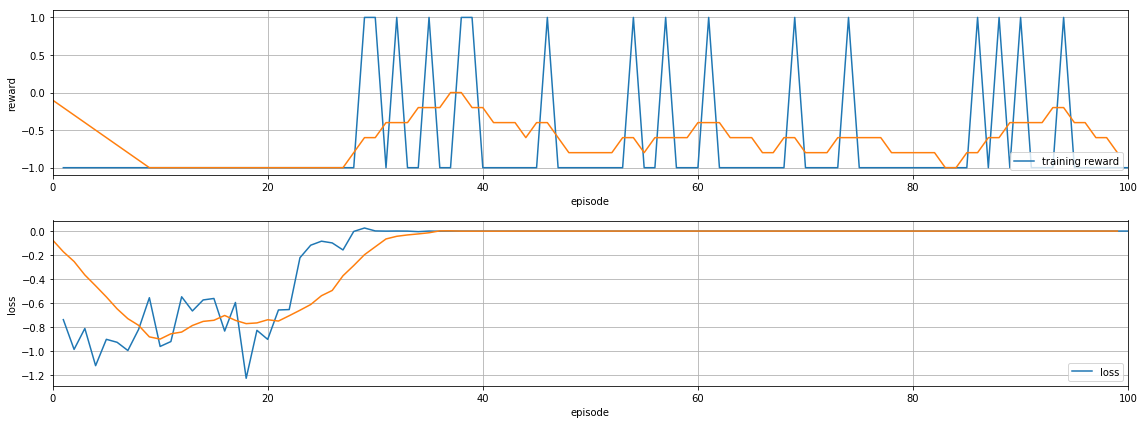

In [23]:
# plot results
import matplotlib.pyplot as plt

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()